In [ ]:
# 0:vcd, 2:glc, 3:lac, 4:amm, 7:igg
tn = 7

# **Base**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AI Bioprocess/Data/~220915
!pwd
!ls
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/MyDrive/AI Bioprocess/Data/~220915
/content/drive/MyDrive/AI Bioprocess/Data/~220915
ammonia.csv	igg_qc.csv	     lactate.csv	 ph_rt.csv
ammonia_qc.csv	igg_rt.csv	     lactate_qc.csv	 vcd.csv
ammonia_rt.csv	input_ammonia.csv    lactate_rt.csv	 vcd_qc.csv
do.csv		input_do.csv	     output_ammonia.csv  vcd_rt.csv
do_qc.csv	input_glucose.csv    output_glucose.csv  viability.csv
do_rt.csv	input_igg.csv	     output_igg.csv	 viability_qc.csv
glucose.csv	input_lactate.csv    output_lactate.csv  viability_rt.csv
glucose_qc.csv	input_ph.csv	     output_vcd.csv
glucose_rt.csv	input_vcd.csv	     ph.csv
igg.csv		input_viability.csv  ph_qc.csv


In [ ]:
hp_svm     = [[5,2],[],[1,0.1],[1,0.1],[1,0.1],[],[],[1,0.1]]
hp_ann_lr  = [0.1, 0, 0.01,  0.03, 0.03, 0,0, 0.03]
hp_rnn_lr  = [0.1, 0, 0.008, 0.03, 0.03, 0,0, 0.03]
hp_lstm_lr = [0.5, 0, 0.5,   0.03, 0.03, 0,0, 0.03]
hp_gru_lr  = [2.5, 0, 0.1,   0.03, 0.03, 0,0, 0.03]

hp_lr = [0,0,0,0,0,0,0,0,0,0,0,0,hp_ann_lr[tn],hp_rnn_lr[tn],hp_lstm_lr[tn],hp_gru_lr[tn]]

units = ['($10^6$ cells/mL)',0,'(g/L)','(g/L)','(mM)',0,0,'(g/L)']

In [ ]:
import os
import random
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as rse


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
import time
import warnings
from math import ceil

In [ ]:
# Functions

def seed_fix():
  seed = 1337
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.compat.v1.set_random_seed(seed)
  config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
  K.set_session(sess)

# 모델 준비
seed_fix()
def build_LR():
  model = LinearRegression()
  return model

def build_LASSO():
  model = Lasso(alpha=0.03)
  return model

def build_EN():
  model = ElasticNet(alpha=0.03)
  return model

def build_KNN():
  model = KNeighborsRegressor()
  return model

def build_CART():
  model = DecisionTreeRegressor()
  return model

def build_GBM():
  model = MultiOutputRegressor(GradientBoostingRegressor())
  return model

def build_XG():
  model = MultiOutputRegressor(XGBRegressor())
  return model

def build_ADA():
  model = MultiOutputRegressor(AdaBoostRegressor())
  return model

def build_SVM():
  model = MultiOutputRegressor(SVR(C=hp_svm[tn][0],epsilon = hp_svm[tn][1]))
  return model

def build_RF():
  model = RandomForestRegressor()
  return model

def build_PLS():
  model = PLSRegression()
  return model

def build_GPR():
  kernel = DotProduct() + WhiteKernel()
  model = GaussianProcessRegressor(kernel=kernel)
  return model

def build_ANN(input_shape,layer_1,layer_2,output_num,Learning_rate):
  seed=1337
  model = keras.Sequential([
                            layers.Dense(layer_1, activation='sigmoid', kernel_initializer=keras.initializers.HeNormal(seed=seed),input_shape=(input_shape,)),
                            layers.Dense(layer_2, activation='sigmoid', kernel_initializer=keras.initializers.HeNormal(seed=seed)),
                            layers.Dense(output_num)
                            ])
  
  optimizer = tf.keras.optimizers.RMSprop(Learning_rate)
  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae','mse']
                )
  return model

def build_RNN(input_feature,units,output_feature,time_step,Learning_rate):
  seed=1337
  model = keras.Sequential()
  model.add(keras.layers.SimpleRNN(units,kernel_initializer=keras.initializers.HeNormal(seed=seed),input_shape=(time_step,input_feature),stateful=False))
  model.add(keras.layers.Dropout(rate=0.1))
  model.add(keras.layers.Dense(units=output_feature,kernel_initializer=keras.initializers.HeNormal(seed=seed)))
  optimizer = tf.keras.optimizers.Adam(learning_rate=Learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
  model.compile(loss='mae', optimizer=optimizer)
  return model

def build_LSTM(input_feature,units,output_feature,time_step,Learning_rate):
  seed=1337
  model = keras.Sequential()
  model.add(keras.layers.LSTM(units,kernel_initializer=keras.initializers.HeNormal(seed=seed),input_shape=(time_step,input_feature),stateful=False))
  model.add(keras.layers.Dropout(rate=0.1))
  model.add(keras.layers.Dense(units=output_feature,kernel_initializer=keras.initializers.HeNormal(seed=seed)))
  optimizer = tf.keras.optimizers.Adam(learning_rate=Learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
  model.compile(loss='mae', optimizer=optimizer)
  return model

def build_GRU(input_feature,units,output_feature,time_step,Learning_rate):
  seed=1337
  model = keras.Sequential()
  model.add(keras.layers.GRU(units,kernel_initializer=keras.initializers.HeNormal(seed=seed),input_shape=(time_step,input_feature),stateful=False))
  model.add(keras.layers.Dropout(rate=0.1))
  model.add(keras.layers.Dense(units=output_feature,kernel_initializer=keras.initializers.HeNormal(seed=seed)))
  optimizer = tf.keras.optimizers.Adam(learning_rate=Learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
  model.compile(loss='mae', optimizer=optimizer)
  return model

def make_recursive(data):
  X = np.zeros((data.shape[0]*(data.shape[1]-3),3))
  y = np.zeros((data.shape[0]*(data.shape[1]-3),1))
  for i in range(data.shape[0]):
    for j in range(data.shape[1]-3):
      X[(5*i+j):(5*i+j+1),0:3] = data[i:(i+1),j:(j+3)]
      y[(5*i+j):(5*i+j+1),0:1] = data[i:(i+1),(j+3):(j+4)]
  return X.astype(float), y.astype(float)

def make_direct(data,future):
  X = np.zeros((data.shape[0]*(data.shape[1]-2-future),3))
  y = np.zeros((data.shape[0]*(data.shape[1]-2-future),1))
  for i in range(data.shape[0]):
    for j in range(data.shape[1]-2-future):
      X[((data.shape[1]-2-future)*i+j):((data.shape[1]-2-future)*i+j+1),0:3] = data[i:(i+1),j:(j+3)]
      y[((data.shape[1]-2-future)*i+j):((data.shape[1]-2-future)*i+j+1),0:1] = data[i:(i+1),(j+2+future):(j+3+future)]
  return X.astype(float), y.astype(float)

def make_mimo(data):
  X = np.zeros((data.shape[0],4))
  y = np.zeros((data.shape[0],4))
  for i in range(data.shape[0]):
    X[i:(i+1),0:4] = data[i:(i+1),0:4]
    y[i:(i+1),0:4] = data[i:(i+1),4:8]
  return X.astype(float), y.astype(float)

def make_dirrec(data,future):
  X = np.zeros((data.shape[0]*(data.shape[1]-2-future),2+future))
  y = np.zeros((data.shape[0]*(data.shape[1]-2-future),1))
  for i in range(data.shape[0]):
    for j in range(data.shape[1]-2-future):
      X[((data.shape[1]-2-future)*i+j):((data.shape[1]-2-future)*i+j+1),0:(2+future)] = data[i:(i+1),j:(j+future+2)]
      y[((data.shape[1]-2-future)*i+j):((data.shape[1]-2-future)*i+j+1),0:1] = data[i:(i+1),(j+2+future):(j+3+future)]
  return X.astype(float), y.astype(float)

def make_dirmo3(data):
  X = np.zeros((data.shape[0]*(data.shape[1]-5),3))
  y = np.zeros((data.shape[0]*(data.shape[1]-5),3))
  for i in range(data.shape[0]):
    for j in range(data.shape[1]-5):
      X[((data.shape[1]-5)*i+j):((data.shape[1]-5)*i+j+1),0:3] = data[i:(i+1),j:(j+3)]
      y[((data.shape[1]-5)*i+j):((data.shape[1]-5)*i+j+1),0:3] = data[i:(i+1),(j+3):(j+6)]
  return X.astype(float), y.astype(float)

def make_dirmo2(data):
  X = np.zeros((data.shape[0]*(data.shape[1]-7),3))
  y = np.zeros((data.shape[0]*(data.shape[1]-7),2))
  for i in range(data.shape[0]):
    for j in range(data.shape[1]-7):
      X[((data.shape[1]-7)*i+j):((data.shape[1]-7)*i+j+1),0:3] = data[i:(i+1),j:(j+3)]
      y[((data.shape[1]-7)*i+j):((data.shape[1]-7)*i+j+1),0:2] = data[i:(i+1),(j+6):(j+8)]
  return X.astype(float), y.astype(float)

def algorithm_selection(a,input_num,output_num,input_feature,units,output_feature,time_step,Learning_rate):
  if a == 0:
    model = build_LR()
  elif a == 1:
    model = build_LASSO()
  elif a == 2:
    model = build_EN()
  elif a == 3:
    model = build_KNN()
  elif a == 4:
    model = build_CART()
  elif a == 5:
    model = build_GBM()
  elif a == 6:
    model = build_XG()
  elif a == 7:
    model = build_ADA()
  elif a == 8:
    model = build_SVM()
  elif a == 9:
    model = build_RF()
  elif a == 10:
    model = build_PLS()
  elif a == 11:
    model = build_GPR()
  elif a == 12:
    model = build_ANN(input_num,input_num,ceil(input_num/2),output_num,Learning_rate)
  elif a == 13:
    model = build_RNN(input_feature,units,output_feature,time_step,Learning_rate)
  elif a == 14:
    model = build_LSTM(input_feature,units,output_feature,time_step,Learning_rate)
  elif a == 15:
    model = build_GRU(input_feature,units,output_feature,time_step,Learning_rate)
  return model


def recursive_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  #recursive
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []

  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_recursive(data_train_input[i])[0])
    y_train_stack.append(make_recursive(data_train_output[i])[1])
    X_test_stack.append(make_recursive(data_test_input[i])[0])
    y_test_stack.append(make_recursive(data_test_output[i])[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_recursive(data_train_output[len(all_vcd_com)])[1])
    y_test_stack.append(make_recursive(data_test_output[len(all_vcd_com)])[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  if mn != 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i])
  elif mn == 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)
  
  address1 = []
  address2 = []
  address1 = list(np.arange(0,out_list.index(tn)))
  address2 = list(np.arange(out_list.index(tn)+len(out_list)-len(all_vcd_com), len(out_list)))
  address1.extend(address2)

  conditions = []
  conditions.append(X_test_list[0].reshape(20,-1,3)[0,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[5,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[10,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[15,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:4])
  y_pred_all = conditions.copy()

  for cn in range(4):
    VCD_tem[cn] = np.concatenate([VCD_tem[cn],np.zeros(shape=(VCD_tem[cn].shape[0],8-VCD_tem[cn].shape[1]))],1)
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)


  #recursive
  for cn in range(4):
    for day in range(5):
      VCD_tem[cn][:,(day+3):(day+4)] = models[0].predict(scaler_list[0].transform(VCD_tem[cn][:,day:(day+3)].reshape(1,VCD_tem[cn].shape[0]*3))).T[address1]
      y_pred_all[cn][day+3] = models[0].predict(scaler_list[0].transform(VCD_tem[cn][:,day:(day+3)].reshape(1,VCD_tem[cn].shape[0]*3))).T[out_list.index(tn)]

  return y_pred_all, np.concatenate([y_pred_all[0][3:8],y_pred_all[1][3:8],y_pred_all[2][3:8],y_pred_all[3][3:8]])


def direct_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []
  # direct 1
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],1)[0])
    X_test_stack.append(make_direct(data_test_input[i],1)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],1)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],1)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # direct 2
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],2)[0])
    X_test_stack.append(make_direct(data_test_input[i],2)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],2)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],2)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # direct 3
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],3)[0])
    X_test_stack.append(make_direct(data_test_input[i],3)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],3)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],3)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # direct 4
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],4)[0])
    X_test_stack.append(make_direct(data_test_input[i],4)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],4)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],4)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # direct 5
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],5)[0])
    X_test_stack.append(make_direct(data_test_input[i],5)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],5)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],5)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  if mn != 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i])
  elif mn == 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)

  conditions = []
  conditions.append(X_test_list[0].reshape(20,-1,3)[0,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[5,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[10,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[15,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:4])
  y_pred_all = conditions.copy()

  for cn in range(4):
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)

  # direct
  for cn in range(4):
    for pm in range(5):
      y_pred_all[cn][pm+3] = models[pm].predict(scaler_list[pm].transform(VCD_tem[cn][:,0:3].reshape(1,VCD_tem[cn].shape[0]*3))).reshape(1)

  return y_pred_all, np.concatenate([y_pred_all[0][3:8],y_pred_all[1][3:8],y_pred_all[2][3:8],y_pred_all[3][3:8]])


def mimo_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  # MIMO
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []

  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_mimo(data_train_input[i])[0])
    X_test_stack.append(make_mimo(data_test_input[i])[0])
  y_train_stack.append(make_mimo(data_train_output[out_list.index(tn)])[1])
  y_test_stack.append(make_mimo(data_test_output[out_list.index(tn)])[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  if mn != 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i])
  elif mn == 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)

  conditions = []
  conditions.append(X_test_list[0].reshape(4,-1,4)[0,:,:])
  conditions.append(X_test_list[0].reshape(4,-1,4)[1,:,:])
  conditions.append(X_test_list[0].reshape(4,-1,4)[2,:,:])
  conditions.append(X_test_list[0].reshape(4,-1,4)[3,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:5])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:5])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:5])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:5])
  y_pred_all = conditions.copy()

  for cn in range(4):
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)

  # MIMO
  for cn in range(4):
    y_pred_all[cn][4:8] = models[0].predict(scaler_list[0].transform(VCD_tem[cn][:,0:4].reshape(1,VCD_tem[cn].shape[0]*4))).reshape(4)

  return y_pred_all, np.concatenate([y_pred_all[0][4:8],y_pred_all[1][4:8],y_pred_all[2][4:8],y_pred_all[3][4:8]])



def dirrec_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []
  # dirrec 1
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],1)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],1)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],1)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],1)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],1)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],1)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # dirrec 2
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],2)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],2)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],2)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],2)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],2)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],2)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # dirrec 3
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],3)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],3)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],3)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],3)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],3)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],3)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # dirrec 4
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],4)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],4)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],4)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],4)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],4)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],4)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # dirrec 5
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],5)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],5)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],5)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],5)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],5)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],5)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  if mn != 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i])
  elif mn == 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)
  
  address1 = []
  address2 = []
  address1 = list(np.arange(0,out_list.index(tn)))
  address2 = list(np.arange(out_list.index(tn)+len(out_list)-len(all_vcd_com), len(out_list)))
  address1.extend(address2)

  conditions = []
  conditions.append(X_test_list[0].reshape(20,-1,3)[0,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[5,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[10,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[15,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:4])
  y_pred_all = conditions.copy()

  for cn in range(4):
    VCD_tem[cn] = np.concatenate([VCD_tem[cn],np.zeros(shape=(VCD_tem[cn].shape[0],8-VCD_tem[cn].shape[1]))],1)
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)
  for cn in range(4):
    for day in range(5):
      VCD_tem[cn][:,(day+3):(day+4)] = models[day].predict(scaler_list[day].transform(VCD_tem[cn][:,0:(day+3)].reshape(1,VCD_tem[cn].shape[0]*(3+day)))).T[address1]
      y_pred_all[cn][day+3] = models[day].predict(scaler_list[day].transform(VCD_tem[cn][:,0:(day+3)].reshape(1,VCD_tem[cn].shape[0]*(3+day)))).T[out_list.index(tn)]

  return y_pred_all, np.concatenate([y_pred_all[0][3:8],y_pred_all[1][3:8],y_pred_all[2][3:8],y_pred_all[3][3:8]])


def dirmo_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  # dirmo 1
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []

  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirmo3(data_train_input[i])[0])
    X_test_stack.append(make_dirmo3(data_test_input[i])[0])
  y_train_stack.append(make_dirmo3(data_train_output[out_list.index(tn)])[1])
  y_test_stack.append(make_dirmo3(data_test_output[out_list.index(tn)])[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirmo2(data_train_input[i])[0])
    X_test_stack.append(make_dirmo2(data_test_input[i])[0])
  y_train_stack.append(make_dirmo2(data_train_output[out_list.index(tn)])[1])
  y_test_stack.append(make_dirmo2(data_test_output[out_list.index(tn)])[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  if mn != 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i])
  elif mn == 12:
    for i in range(len(X_train_s_list)):
      seed_fix()
      models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)

  conditions = []
  conditions.append(X_test_list[0].reshape(12,-1,3)[0,:,:])
  conditions.append(X_test_list[0].reshape(12,-1,3)[3,:,:])
  conditions.append(X_test_list[0].reshape(12,-1,3)[6,:,:])
  conditions.append(X_test_list[0].reshape(12,-1,3)[9,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:4])
  y_pred_all = conditions.copy()

  for cn in range(4):
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)

  # dirmo
  for cn in range(4):
    y_pred_all[cn][3:6] = models[0].predict(scaler_list[0].transform(VCD_tem[cn][:,0:3].reshape(1,VCD_tem[cn].shape[0]*3))).reshape(3)
    y_pred_all[cn][6:8] = models[1].predict(scaler_list[1].transform(VCD_tem[cn][:,0:3].reshape(1,VCD_tem[cn].shape[0]*3))).reshape(2)
  
  return y_pred_all, np.concatenate([y_pred_all[0][3:8],y_pred_all[1][3:8],y_pred_all[2][3:8],y_pred_all[3][3:8]])


##########################################################################################################
##########################################################################################################
##########################################################################################################

def recursive_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  #recursive
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []

  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_recursive(data_train_input[i])[0])
    y_train_stack.append(make_recursive(data_train_output[i])[1])
    X_test_stack.append(make_recursive(data_test_input[i])[0])
    y_test_stack.append(make_recursive(data_test_output[i])[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_recursive(data_train_output[len(all_vcd_com)])[1])
    y_test_stack.append(make_recursive(data_test_output[len(all_vcd_com)])[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  for i in range(len(X_train_list)):
    X_train_s_list[i] = X_train_s_list[i].reshape(X_train_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)
    X_test_s_list[i]  = X_test_s_list[i].reshape(X_test_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  for i in range(len(X_train_s_list)):
    seed_fix()
    models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)
  
  address1 = []
  address2 = []
  address1 = list(np.arange(0,out_list.index(tn)))
  address2 = list(np.arange(out_list.index(tn)+len(out_list)-len(all_vcd_com), len(out_list)))
  address1.extend(address2)

  conditions = []
  conditions.append(X_test_list[0].reshape(20,-1,3)[0,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[5,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[10,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[15,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:4])
  y_pred_all = conditions.copy()

  for cn in range(4):
    VCD_tem[cn] = np.concatenate([VCD_tem[cn],np.zeros(shape=(VCD_tem[cn].shape[0],8-VCD_tem[cn].shape[1]))],1)
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)


  #recursive
  for cn in range(4):
    for day in range(5):
      VCD_tem[cn][:,(day+3):(day+4)] = models[0].predict(scaler_list[0].transform(VCD_tem[cn][:,day:(day+3)].reshape(1,-1)).reshape(1,VCD_tem[cn][:,day:(day+3)].shape[0],VCD_tem[cn][:,day:(day+3)].shape[1]).transpose(0,2,1),verbose=0).T[address1]
      y_pred_all[cn][day+3] = models[0].predict(scaler_list[0].transform(VCD_tem[cn][:,day:(day+3)].reshape(1,-1)).reshape(1,VCD_tem[cn][:,day:(day+3)].shape[0],VCD_tem[cn][:,day:(day+3)].shape[1]).transpose(0,2,1),verbose=0).T[out_list.index(tn)][0]

  return y_pred_all, np.concatenate([y_pred_all[0][3:8],y_pred_all[1][3:8],y_pred_all[2][3:8],y_pred_all[3][3:8]])


def direct_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []
  # direct 1
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],1)[0])
    X_test_stack.append(make_direct(data_test_input[i],1)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],1)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],1)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # direct 2
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],2)[0])
    X_test_stack.append(make_direct(data_test_input[i],2)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],2)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],2)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # direct 3
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],3)[0])
    X_test_stack.append(make_direct(data_test_input[i],3)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],3)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],3)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # direct 4
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],4)[0])
    X_test_stack.append(make_direct(data_test_input[i],4)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],4)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],4)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # direct 5
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_direct(data_train_input[i],5)[0])
    X_test_stack.append(make_direct(data_test_input[i],5)[0])
  y_train_stack.append(make_direct(data_train_output[out_list.index(tn)],5)[1])
  y_test_stack.append(make_direct(data_test_output[out_list.index(tn)],5)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  for i in range(len(X_train_list)):
    X_train_s_list[i] = X_train_s_list[i].reshape(X_train_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)
    X_test_s_list[i]  = X_test_s_list[i].reshape(X_test_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  for i in range(len(X_train_s_list)):
    seed_fix()
    models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)

  conditions = []
  conditions.append(X_test_list[0].reshape(20,-1,3)[0,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[5,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[10,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[15,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:4])
  y_pred_all = conditions.copy()

  for cn in range(4):
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)

  # direct
  for cn in range(4):
    for pm in range(5):
      y_pred_all[cn][pm+3] = models[pm].predict(scaler_list[pm].transform(VCD_tem[cn][:,0:3].reshape(1,-1)).reshape(1,VCD_tem[cn][:,0:3].shape[0],VCD_tem[cn][:,0:3].shape[1]).transpose(0,2,1),verbose=0).reshape(1)[0]

  return y_pred_all, np.concatenate([y_pred_all[0][3:8],y_pred_all[1][3:8],y_pred_all[2][3:8],y_pred_all[3][3:8]])


def mimo_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  # MIMO
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []

  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_mimo(data_train_input[i])[0])
    X_test_stack.append(make_mimo(data_test_input[i])[0])
  y_train_stack.append(make_mimo(data_train_output[out_list.index(tn)])[1])
  y_test_stack.append(make_mimo(data_test_output[out_list.index(tn)])[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  for i in range(len(X_train_list)):
    X_train_s_list[i] = X_train_s_list[i].reshape(X_train_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)
    X_test_s_list[i]  = X_test_s_list[i].reshape(X_test_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  for i in range(len(X_train_s_list)):
    seed_fix()
    models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)

  conditions = []
  conditions.append(X_test_list[0].reshape(4,-1,4)[0,:,:])
  conditions.append(X_test_list[0].reshape(4,-1,4)[1,:,:])
  conditions.append(X_test_list[0].reshape(4,-1,4)[2,:,:])
  conditions.append(X_test_list[0].reshape(4,-1,4)[3,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:5])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:5])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:5])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:5])
  y_pred_all = conditions.copy()

  for cn in range(4):
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)

  # MIMO
  for cn in range(4):
    y_pred_all[cn][4:8] = models[0].predict(scaler_list[0].transform(VCD_tem[cn][:,0:4].reshape(1,-1)).reshape(1,VCD_tem[cn][:,0:4].shape[0],VCD_tem[cn][:,0:4].shape[1]).transpose(0,2,1),verbose=0).reshape(4)

  return y_pred_all, np.concatenate([y_pred_all[0][4:8],y_pred_all[1][4:8],y_pred_all[2][4:8],y_pred_all[3][4:8]])



def dirrec_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []
  # dirrec 1
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],1)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],1)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],1)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],1)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],1)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],1)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # dirrec 2
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],2)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],2)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],2)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],2)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],2)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],2)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # dirrec 3
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],3)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],3)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],3)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],3)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],3)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],3)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # dirrec 4
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],4)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],4)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],4)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],4)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],4)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],4)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))
  # dirrec 5
  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirrec(data_train_input[i],5)[0])
    X_test_stack.append(make_dirrec(data_test_input[i],5)[0])
    y_train_stack.append(make_dirrec(data_train_output[i],5)[1])
    y_test_stack.append(make_dirrec(data_test_output[i],5)[1])
  if tn not in all_vcd_com:
    y_train_stack.append(make_dirrec(data_train_output[len(all_vcd_com)],5)[1])
    y_test_stack.append(make_dirrec(data_test_output[len(all_vcd_com)],5)[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  for i in range(len(X_train_list)):
    X_train_s_list[i] = X_train_s_list[i].reshape(X_train_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)
    X_test_s_list[i]  = X_test_s_list[i].reshape(X_test_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  for i in range(len(X_train_s_list)):
    seed_fix()
    models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)
  
  address1 = []
  address2 = []
  address1 = list(np.arange(0,out_list.index(tn)))
  address2 = list(np.arange(out_list.index(tn)+len(out_list)-len(all_vcd_com), len(out_list)))
  address1.extend(address2)

  conditions = []
  conditions.append(X_test_list[0].reshape(20,-1,3)[0,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[5,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[10,:,:])
  conditions.append(X_test_list[0].reshape(20,-1,3)[15,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:4])
  y_pred_all = conditions.copy()

  for cn in range(4):
    VCD_tem[cn] = np.concatenate([VCD_tem[cn],np.zeros(shape=(VCD_tem[cn].shape[0],8-VCD_tem[cn].shape[1]))],1)
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)
  for cn in range(4):
    for day in range(5):
      VCD_tem[cn][:,(day+3):(day+4)] = models[day].predict(scaler_list[day].transform(VCD_tem[cn][:,0:(day+3)].reshape(1,-1)).reshape(1,VCD_tem[cn][:,0:(day+3)].shape[0],VCD_tem[cn][:,0:(day+3)].shape[1]).transpose(0,2,1),verbose=0).T[address1]
      y_pred_all[cn][day+3] = models[day].predict(scaler_list[day].transform(VCD_tem[cn][:,0:(day+3)].reshape(1,-1)).reshape(1,VCD_tem[cn][:,0:(day+3)].shape[0],VCD_tem[cn][:,0:(day+3)].shape[1]).transpose(0,2,1),verbose=0).T[out_list.index(tn)][0]
  
  return y_pred_all, np.concatenate([y_pred_all[0][3:8],y_pred_all[1][3:8],y_pred_all[2][3:8],y_pred_all[3][3:8]])


def dirmo_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  out_list = list(all_vcd_com).copy()
  if tn not in all_vcd_com:
    out_list.append(tn)
    out_list.sort()

  data_train_input = []
  data_test_input = []
  for i in all_vcd_com:
    data_train_input.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_input.append(raw_data[i][condition_test].to_numpy()[:,1:9])
  data_train_output = []
  data_test_output = []
  for i in out_list:
    data_train_output.append(raw_data[i][condition_train].to_numpy()[:,1:9])
    data_test_output.append(raw_data[i][condition_test].to_numpy()[:,1:9])

  # dirmo 1
  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []

  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirmo3(data_train_input[i])[0])
    X_test_stack.append(make_dirmo3(data_test_input[i])[0])
  y_train_stack.append(make_dirmo3(data_train_output[out_list.index(tn)])[1])
  y_test_stack.append(make_dirmo3(data_test_output[out_list.index(tn)])[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_stack = []
  y_train_stack = []
  X_test_stack = []
  y_test_stack = []
  for i in range(len(all_vcd_com)):
    X_train_stack.append(make_dirmo2(data_train_input[i])[0])
    X_test_stack.append(make_dirmo2(data_test_input[i])[0])
  y_train_stack.append(make_dirmo2(data_train_output[out_list.index(tn)])[1])
  y_test_stack.append(make_dirmo2(data_test_output[out_list.index(tn)])[1])
  X_train_list.append(np.hstack(X_train_stack))
  y_train_list.append(np.hstack(y_train_stack))
  X_test_list.append(np.hstack(X_test_stack))
  y_test_list.append(np.hstack(y_test_stack))

  X_train_s_list = []
  X_test_s_list = []
  scaler_list = []
  for i in range(len(X_train_list)):
    scaler = StandardScaler()
    X_train_s_list.append(scaler.fit_transform(X_train_list[i]))
    X_test_s_list.append(scaler.transform(X_test_list[i]))
    scaler_list.append(scaler)

  for i in range(len(X_train_list)):
    X_train_s_list[i] = X_train_s_list[i].reshape(X_train_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)
    X_test_s_list[i]  = X_test_s_list[i].reshape(X_test_s_list[i].shape[0],len(all_vcd_com),-1).transpose(0,2,1)

  models = []
  for i in range(len(X_train_s_list)):
    seed_fix()
    models.append(algorithm_selection(mn,X_train_s_list[i].shape[1],y_train_list[i].shape[1],len(all_vcd_com),len(all_vcd_com),y_train_list[i].shape[1],X_test_s_list[i].shape[1],Learning_rate))

  for i in range(len(X_train_s_list)):
    seed_fix()
    models[i].fit(X_train_s_list[i],y_train_list[i],epochs=100,verbose=0)

  conditions = []
  conditions.append(X_test_list[0].reshape(12,-1,3)[0,:,:])
  conditions.append(X_test_list[0].reshape(12,-1,3)[3,:,:])
  conditions.append(X_test_list[0].reshape(12,-1,3)[6,:,:])
  conditions.append(X_test_list[0].reshape(12,-1,3)[9,:,:])
  VCD_tem = conditions.copy()

  conditions = []
  conditions.append(raw_data[tn][condition_test].to_numpy()[0,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[1,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[2,1:4])
  conditions.append(raw_data[tn][condition_test].to_numpy()[3,1:4])
  y_pred_all = conditions.copy()

  for cn in range(4):
    y_pred_all[cn] = np.concatenate([y_pred_all[cn],np.zeros(shape=(8-y_pred_all[cn].shape[0]))],0)

  # dirmo
  for cn in range(4):
    y_pred_all[cn][3:6] = models[0].predict(scaler_list[0].transform(VCD_tem[cn][:,0:3].reshape(1,-1)).reshape(1,VCD_tem[cn][:,0:3].shape[0],VCD_tem[cn][:,0:3].shape[1]).transpose(0,2,1),verbose=0).reshape(3)
    y_pred_all[cn][6:8] = models[1].predict(scaler_list[1].transform(VCD_tem[cn][:,0:3].reshape(1,-1)).reshape(1,VCD_tem[cn][:,0:3].shape[0],VCD_tem[cn][:,0:3].shape[1]).transpose(0,2,1),verbose=0).reshape(2)

  
  return y_pred_all, np.concatenate([y_pred_all[0][3:8],y_pred_all[1][3:8],y_pred_all[2][3:8],y_pred_all[3][3:8]])


##########################################################################################################
##########################################################################################################
##########################################################################################################


def forecasting_selection(RNN,f,all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate):
  if RNN == 0 and f == 0:
    return recursive_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)
  elif RNN == 0 and f == 1:
    return direct_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)
  elif RNN == 0 and f == 2:
    return mimo_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)
  elif RNN == 0 and f == 3:
    return dirrec_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)
  elif RNN == 0 and f == 4:
    return dirmo_predict(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)
  elif RNN == 1 and f == 0:
    return recursive_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)
  elif RNN == 1 and f == 1:
    return direct_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)
  elif RNN == 1 and f == 2:
    return mimo_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)
  elif RNN == 1 and f == 3:
    return dirrec_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)
  elif RNN == 1 and f == 4:
    return dirmo_predict_RNN(all_vcd_com,mn,raw_data,condition_train,condition_test,Learning_rate)


# **Evaluation process**

In [ ]:
start = time.time()  # 시작 시간 저장
warnings.filterwarnings("ignore")
### data 준비 ###
# one step input
seed_fix()
data_input = []
data_input.append(pd.read_csv("input_vcd.csv"))
data_input.append(pd.read_csv("input_viability.csv"))
data_input.append(pd.read_csv("input_glucose.csv"))
data_input.append(pd.read_csv("input_lactate.csv"))
data_input.append(pd.read_csv("input_ammonia.csv"))
data_input.append(pd.read_csv("input_do.csv"))
data_input.append(pd.read_csv("input_ph.csv"))
data_input.append(pd.read_csv("input_igg.csv"))

# one step output
data_output = []
data_output.append(pd.read_csv("output_vcd.csv"))
data_output.append(pd.read_csv("input_viability.csv"))
data_output.append(pd.read_csv("output_glucose.csv"))
data_output.append(pd.read_csv("output_lactate.csv"))
data_output.append(pd.read_csv("output_ammonia.csv"))
data_output.append(pd.read_csv("input_do.csv"))
data_output.append(pd.read_csv("input_ph.csv"))
data_output.append(pd.read_csv("output_igg.csv"))

# multistep data
raw_data = []
raw_data.append(pd.read_csv('vcd.csv'))
raw_data.append(pd.read_csv('viability.csv'))
raw_data.append(pd.read_csv('glucose.csv'))
raw_data.append(pd.read_csv('lactate.csv'))
raw_data.append(pd.read_csv('ammonia.csv'))
raw_data.append(pd.read_csv('do.csv'))
raw_data.append(pd.read_csv('ph.csv'))
raw_data.append(pd.read_csv('igg.csv'))

# test batches for each condition
condition_test1 = "P1_1"
condition_test2 = "P2_2"
condition_test3 = "P3_5"
condition_test4 = "P4_6"
condition_test_os  = (data_input[0].condition == condition_test1) + (data_input[0].condition == condition_test2) + (data_input[0].condition == condition_test3) + (data_input[0].condition == condition_test4)
condition_train_os = ~condition_test_os
condition_train_ms = ~((raw_data[0].condition == condition_test1) + (raw_data[0].condition == condition_test2) + (raw_data[0].condition == condition_test3) + (raw_data[0].condition == condition_test4))
condition_test_ms  = (raw_data[0].condition == condition_test1) + (raw_data[0].condition == condition_test2) + (raw_data[0].condition == condition_test3) + (raw_data[0].condition == condition_test4)

# permutation item and etc..
item = [0,1,2,3,4,5,6,7]
model_name=np.array(["LR","LASSO","EN","KNN","CART","GBM","XGB","Ada","SVM","RF","PLS","GPR","ANN","RNN","LSTM","GRU"])
forecasting_strategy = np.array(["Recursive",'Direct','MIMO','DirRec','DIRMO'])

################################################################################################################
### Algorithm evaluation #######################################################################################
################################################################################################################

# data split
X_train_os = data_input[0][condition_train_os].to_numpy()[:,1:4]
for i in range(len(list(item))-1):
  X_train_os = np.hstack((X_train_os,data_input[i+1][condition_train_os].to_numpy()[:,1:4]))
y_train_os = data_output[tn][condition_train_os].to_numpy()[:,1:2]

X_test_os = data_input[0][condition_test_os].to_numpy()[:,1:4]
for i in range(len(list(item))-1):
  X_test_os = np.hstack((X_test_os,data_input[i+1][condition_test_os].to_numpy()[:,1:4]))
y_test_os  = data_output[tn][condition_test_os].to_numpy()[:,1:2]

scaler_X         = StandardScaler()
X_train_s_os     = scaler_X.fit_transform(X_train_os)
X_test_s_os      = scaler_X.transform(X_test_os)
X_train_s_rs_os  = X_train_s_os.reshape(X_train_s_os.shape[0],len(list(item)),-1).transpose(0,2,1)
X_test_s_rs_os   = X_test_s_os.reshape(X_test_s_os.shape[0],len(list(item)),-1).transpose(0,2,1)

# building models
Models_vcd_a = []
for mn in range(16):
  Models_vcd_a.append(algorithm_selection(mn,X_train_s_os.shape[1],y_train_os.shape[1],X_train_s_rs_os.shape[2],X_train_s_rs_os.shape[2],y_train_os.shape[1],3,hp_lr[mn]))

# training models
for mn in range(12):
  seed_fix()
  Models_vcd_a[mn].fit(X_train_s_os.astype(float),y_train_os.astype(float))
seed_fix()
Models_vcd_a[12].fit(X_train_s_os.astype(float),y_train_os.astype(float),epochs=100,verbose=0)
for mn in [13,14,15]:
  seed_fix()
  Models_vcd_a[mn].fit(X_train_s_rs_os.astype(float),y_train_os.astype(float),epochs=100,verbose=0)

# evaluating models
error_table_a_mae = []
error_table_a_mape = []
error_table_a_mse = []
error_table_a_rmse = []
error_table_a_rse = []
for mn in range(13):
  error_table_a_mae.append(mae(y_test_os,Models_vcd_a[mn].predict(X_test_s_os)))
  error_table_a_mape.append(mape(y_test_os,Models_vcd_a[mn].predict(X_test_s_os)))
  error_table_a_mse.append(mse(y_test_os,Models_vcd_a[mn].predict(X_test_s_os)))
  error_table_a_rmse.append(mse(y_test_os,Models_vcd_a[mn].predict(X_test_s_os),squared=False))
  error_table_a_rse.append(rse(y_test_os,Models_vcd_a[mn].predict(X_test_s_os)))
for mn in [13,14,15]:
  error_table_a_mae.append(mae(y_test_os,Models_vcd_a[mn].predict(X_test_s_rs_os,verbose=0)))
  error_table_a_mape.append(mape(y_test_os,Models_vcd_a[mn].predict(X_test_s_rs_os,verbose=0)))
  error_table_a_mse.append(mse(y_test_os,Models_vcd_a[mn].predict(X_test_s_rs_os,verbose=0)))
  error_table_a_rmse.append(mse(y_test_os,Models_vcd_a[mn].predict(X_test_s_rs_os,verbose=0),squared=False))
  error_table_a_rse.append(rse(y_test_os,Models_vcd_a[mn].predict(X_test_s_rs_os,verbose=0)))

best_algorithm_no = error_table_a_mape.index(min(error_table_a_mape))

##############################################################################################################################
### input process parameter evaluation #######################################################################################
##############################################################################################################################

error_table_i_mae   = []
error_table_i_mape  = []
error_table_i_mse   = []
error_table_i_rmse  = []
error_table_i_rse   = []
best_error_vcd_mape = 100

com_list = []
for k in range(8):
  com = list(combinations(item,k+1))
  for i in range(len(com)):
    com_list.append(com[i])

for i in range(len(com_list)):
  X_train = data_input[list(com_list[i])[0]][condition_train_os].to_numpy()[:,1:4]
  X_test  = data_input[list(com_list[i])[0]][condition_test_os].to_numpy()[:,1:4]
  for j in range(len(list(com_list[i]))-1):
    X_train = np.hstack((X_train,data_input[list(com_list[i])[j+1]][condition_train_os].to_numpy()[:,1:4]))
    X_test = np.hstack((X_test,data_input[list(com_list[i])[j+1]][condition_test_os].to_numpy()[:,1:4]))

  scaler_X      = StandardScaler()
  X_train_s     = scaler_X.fit_transform(X_train)
  X_test_s      = scaler_X.transform(X_test)
  X_train_s_rs  = X_train_s.reshape(X_train_s.shape[0],len(list(com_list[i])),-1).transpose(0,2,1)
  X_test_s_rs   = X_test_s.reshape(X_test_s.shape[0],len(list(com_list[i])),-1).transpose(0,2,1)

  Models_vcd_i = []
  Models_vcd_i.append(algorithm_selection(best_algorithm_no,X_train_s.shape[1],y_train_os.shape[1],X_train_s_rs.shape[2],X_train_s_rs.shape[2],y_train_os.shape[1],3,hp_lr[best_algorithm_no]))

  if best_algorithm_no in range(13):
    seed_fix()
    Models_vcd_i[0].fit(X_train_s.astype(float),y_train_os.astype(float))
    error_table_i_mae.append(mae(y_test_os,Models_vcd_i[0].predict(X_test_s)))
    error_table_i_mape.append(mape(y_test_os,Models_vcd_i[0].predict(X_test_s)))
    error_table_i_mse.append(mse(y_test_os,Models_vcd_i[0].predict(X_test_s)))
    error_table_i_rmse.append(mse(y_test_os,Models_vcd_i[0].predict(X_test_s),squared=False))
    error_table_i_rse.append(rse(y_test_os,Models_vcd_i[0].predict(X_test_s)))
    if mape(y_test_os,Models_vcd_i[0].predict(X_test_s)) < best_error_vcd_mape:
      best_error_vcd_mae   = mae(y_test_os,Models_vcd_i[0].predict(X_test_s))
      best_error_vcd_mape  = mape(y_test_os,Models_vcd_i[0].predict(X_test_s))
      best_error_vcd_mse   = mse(y_test_os,Models_vcd_i[0].predict(X_test_s))
      best_error_vcd_rmse  = mse(y_test_os,Models_vcd_i[0].predict(X_test_s),squared=False)
      best_error_vcd_rse   = rse(y_test_os,Models_vcd_i[0].predict(X_test_s))
      best_error_vcd_com   = com_list[i]
      best_error_vcd_model = Models_vcd_i[0]
      best_error_vcd_X     = X_test_s  

  else:
    seed_fix()
    Models_vcd_i[0].fit(X_train_s_rs.astype(float),y_train_os.astype(float),epochs=100,verbose=0)
    error_table_i_mae.append(mae(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0)))
    error_table_i_mape.append(mape(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0)))
    error_table_i_mse.append(mse(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0)))
    error_table_i_rmse.append(mse(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0),squared=False))
    error_table_i_rse.append(rse(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0)))
    if mape(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0)) < best_error_vcd_mape:
      best_error_vcd_mae   = mae(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0))
      best_error_vcd_mape  = mape(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0))
      best_error_vcd_mse   = mse(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0))
      best_error_vcd_rmse  = mse(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0),squared=False)
      best_error_vcd_rse   = rse(y_test_os,Models_vcd_i[0].predict(X_test_s_rs,verbose=0))
      best_error_vcd_com   = com_list[i]
      best_error_vcd_model = Models_vcd_i[0]
      best_error_vcd_X     = X_test_s_rs


######################################################################################################################
### forecasting strategy evaluation ##################################################################################
######################################################################################################################

error_table_f_mae = []
error_table_f_mape = []
error_table_f_mse = []
error_table_f_rmse = []
error_table_f_rse = []

y_test_trajectory = []
for i in range(5):
  y_test_trajectory.append(np.concatenate([raw_data[tn][condition_test_ms].to_numpy()[0,4:9],raw_data[tn][condition_test_ms].to_numpy()[1,4:9],raw_data[tn][condition_test_ms].to_numpy()[2,4:9],raw_data[tn][condition_test_ms].to_numpy()[3,4:9]]))
y_test_trajectory[2] = np.concatenate([raw_data[tn][condition_test_ms].to_numpy()[0,5:9],raw_data[tn][condition_test_ms].to_numpy()[1,5:9],raw_data[tn][condition_test_ms].to_numpy()[2,5:9],raw_data[tn][condition_test_ms].to_numpy()[3,5:9]])

mimo_list = list(range(20))
for i in range(4):
  mimo_list.remove(5*i)

y_pred_os_trajectory = []
for i in range(5):
  y_pred_os_trajectory.append(best_error_vcd_model.predict(best_error_vcd_X))
y_pred_os_trajectory[2] = best_error_vcd_model.predict(best_error_vcd_X)[mimo_list]

y_pred_ms_trajectory = []
for f in range(5):
  y_pred_ms_trajectory.append(forecasting_selection(best_algorithm_no//13,f,best_error_vcd_com,best_algorithm_no,raw_data,condition_train_ms,condition_test_ms,hp_lr[best_algorithm_no])[1])
  error_table_f_mae.append(mae(y_test_trajectory[f],y_pred_ms_trajectory[f]))
  error_table_f_mape.append(mape(y_test_trajectory[f],y_pred_ms_trajectory[f]))
  error_table_f_mse.append(mse(y_test_trajectory[f],y_pred_ms_trajectory[f]))
  error_table_f_rmse.append(mse(y_test_trajectory[f],y_pred_ms_trajectory[f],squared=False))
  error_table_f_rse.append(rse(y_test_trajectory[f],y_pred_ms_trajectory[f]))

best_forecasting_no = error_table_f_mape.index(min(error_table_f_mape))

print('the minimum MAPE is ',min(error_table_a_mape)*100,'% and the algorithms is ',model_name[best_algorithm_no])
print('The MAPE of best input combination is ',min(error_table_i_mape)*100,'% and the best input combination is ',best_error_vcd_com)
print('the minimum MAPE is ',min(error_table_f_mape)*100,'% and the forecasting strategy is ',forecasting_strategy[best_forecasting_no])
print('The Best combination is',model_name[best_algorithm_no],best_error_vcd_com,forecasting_strategy[best_forecasting_no])
print('with',
      error_table_f_mae[best_forecasting_no],
      error_table_f_mape[best_forecasting_no],
      error_table_f_mse[best_forecasting_no],
      error_table_f_rmse[best_forecasting_no],
      error_table_f_rse[best_forecasting_no]
      )

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[02:03:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1/1 [==============================] - 0s 27ms/step
the minimum MAPE is  9.298918428179567 % and the algorithms is  GBM
The MAPE of best input combination is  5.590334564847889 % and the best input combination is  (3, 4, 5)
the minimum MAPE is  10.48252145196537 % and the forecasting strategy is  Direct
The Best combination is GBM (3, 4, 5) Direct
with 0.06941182671947714 0.1048252145196537 0.012009581199573256 0.10958823476803181 0.8069934574836717
time : 29.620142936706543


# **Tables**

In [ ]:
### prediction table ###
%cd /content/drive/MyDrive/AI Bioprocess/colab note/BnB/Stepwise/stepwise_error_table
!pwd
!ls

df = pd.DataFrame(y_pred_ms_trajectory[error_table_f_mape.index(min(error_table_f_mape))])
df.to_csv('y_pred_AIF_'+str(tn)+'.csv',index=False)

df = pd.DataFrame(y_test_trajectory[0])
df.to_csv('y_test_'+str(tn)+'.csv',index=False)

/content/drive/MyDrive/AI Bioprocess/colab note/BnB/Stepwise/stepwise_error_table
/content/drive/MyDrive/AI Bioprocess/colab note/BnB/Stepwise/stepwise_error_table


In [ ]:
### Table 1 ###
%cd /content/drive/MyDrive/AI Bioprocess/colab note/BnB/Stepwise/figure/


df = pd.DataFrame(np.concatenate([np.array(error_table_a_mae),
                                  np.array(error_table_a_mape),
                                  np.array(error_table_a_mse),
                                  np.array(error_table_a_rmse),
                                  np.array(error_table_a_rse)]).reshape(5,16).T)

df.to_csv('AIF_table1_'+str(tn)+'.csv',index=False)

df = pd.DataFrame(np.array([
                            [error_table_a_mae[best_algorithm_no],error_table_i_mae[error_table_i_mape.index(min(error_table_i_mape))]],
                            [error_table_a_mape[best_algorithm_no],min(error_table_i_mape)],
                            [error_table_a_mse[best_algorithm_no],error_table_i_mse[error_table_i_mape.index(min(error_table_i_mape))]],
                            [error_table_a_rmse[best_algorithm_no],error_table_i_rmse[error_table_i_mape.index(min(error_table_i_mape))]],
                            [error_table_a_rse[best_algorithm_no],error_table_i_rse[error_table_i_mape.index(min(error_table_i_mape))]]
                        ]))

df.to_csv('AIF_table2_'+str(tn)+'.csv',index=False)

df = pd.DataFrame(np.concatenate([np.array(error_table_f_mae),
                  np.array(error_table_f_mape),
                  np.array(error_table_f_mse),
                  np.array(error_table_f_rmse),
                  np.array(error_table_f_rse)]).reshape(5,5).T)

df.to_csv('AIF_table3_'+str(tn)+'.csv',index=False)

/content/drive/MyDrive/AI Bioprocess/colab note/BnB/Stepwise/figure


# **Figures**

In [ ]:
lim_list = [[-5,45],[],[1,11],[-0.4,3.4],[0,15],[],[],[-0.1, 1.1]]
ticks_list = [[0,10,20,30,40],[],[2,6,10],[0,1,2,3],[2,8,14],[],[],[0,0.5,1]]

1/1 [==============================] - 0s 29ms/step


Text(0.05, 0.5, 'Predicted value (g/L)')

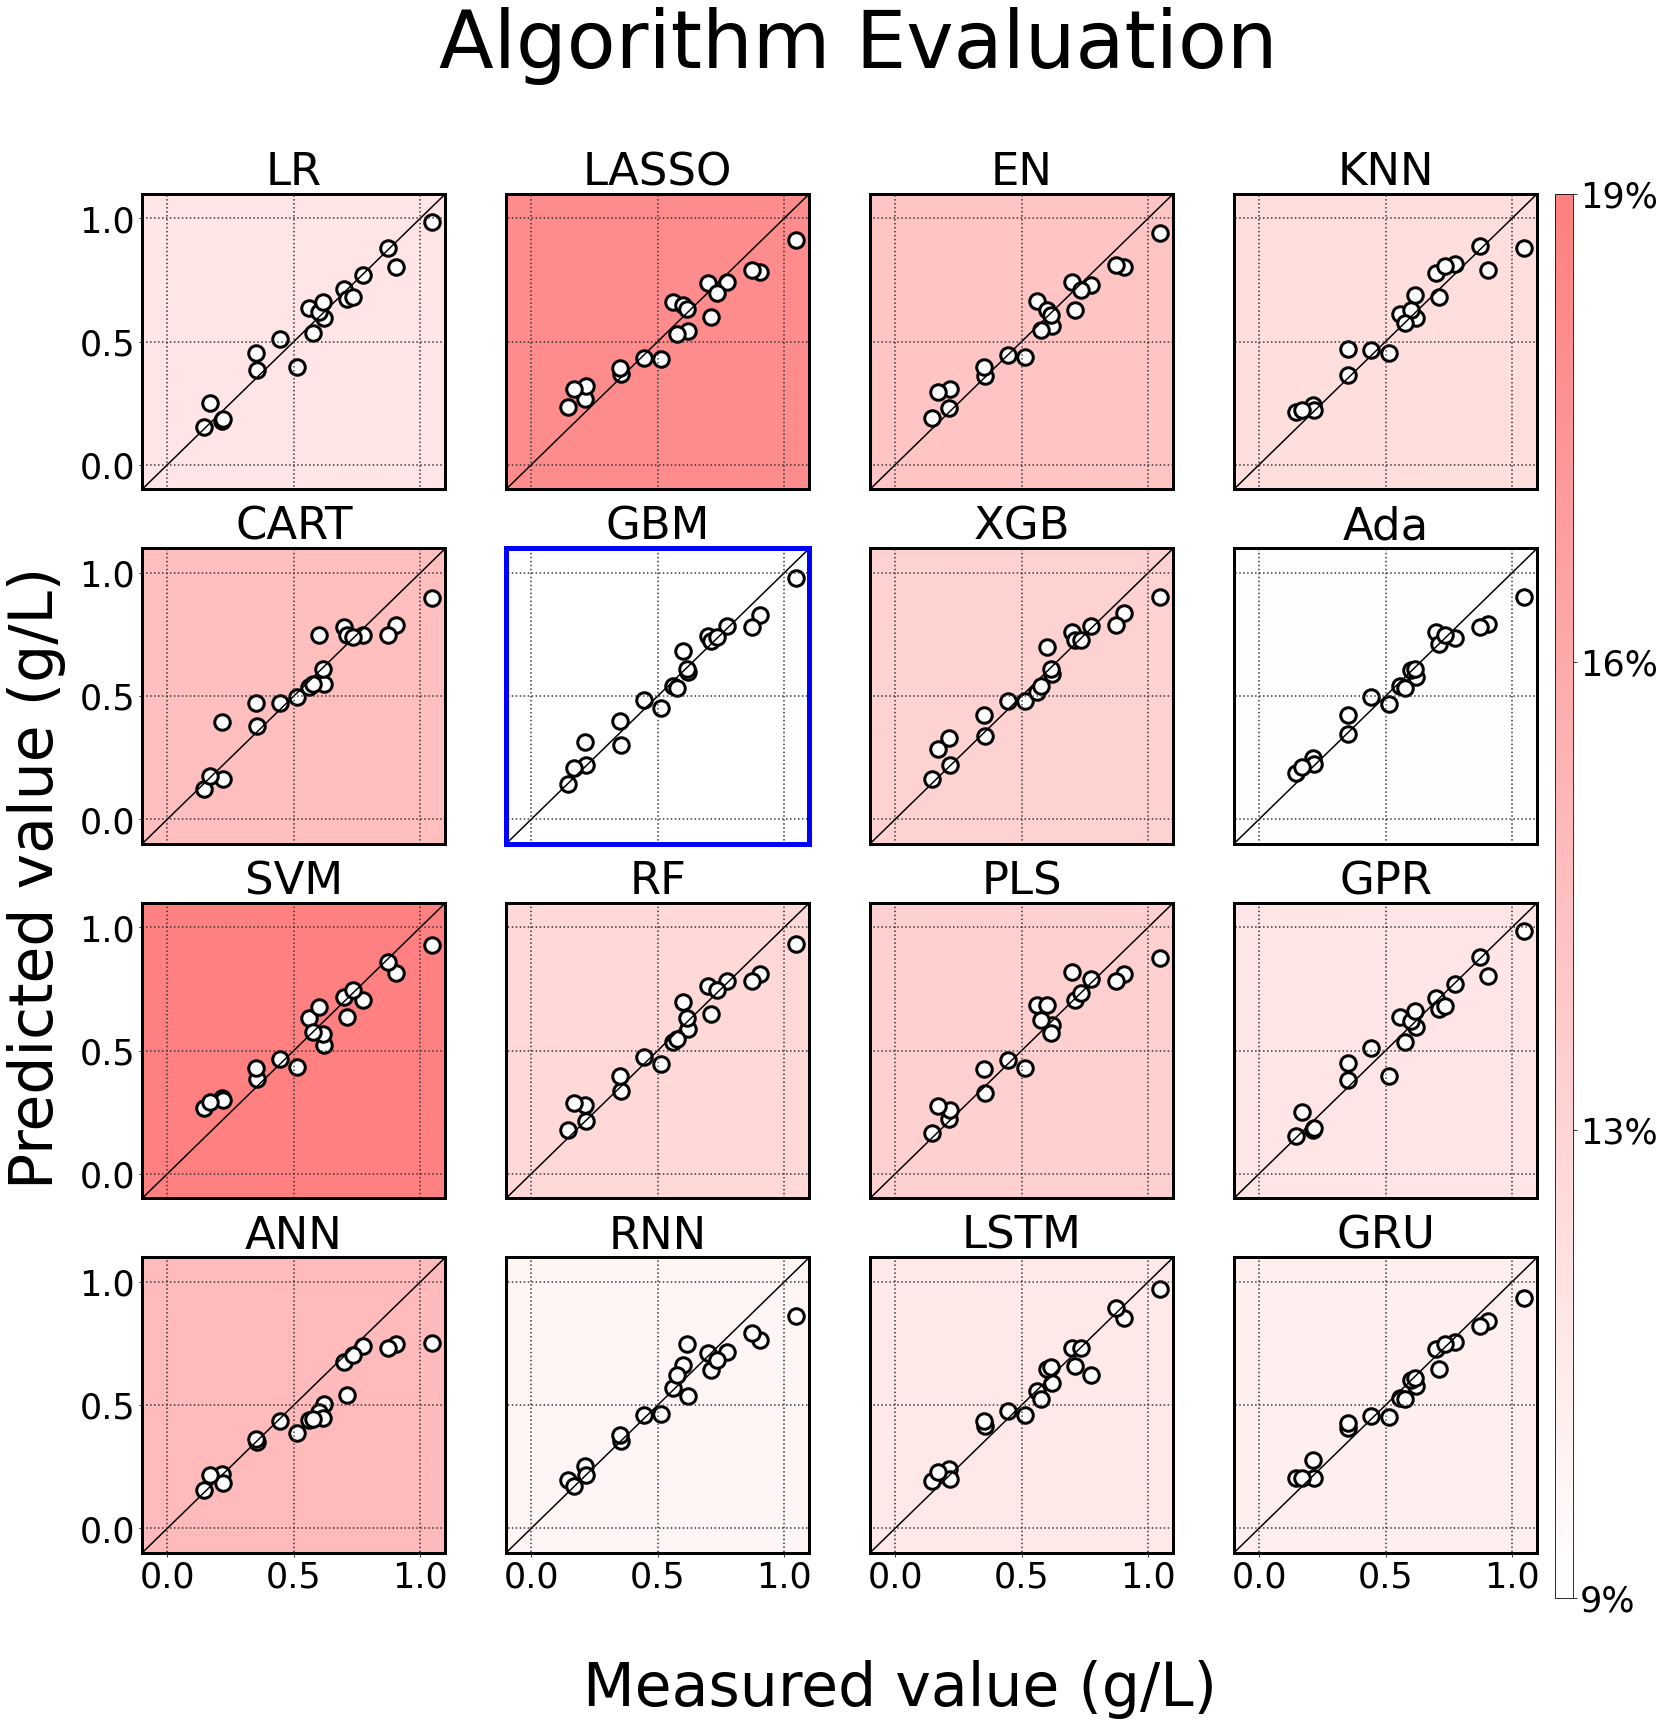

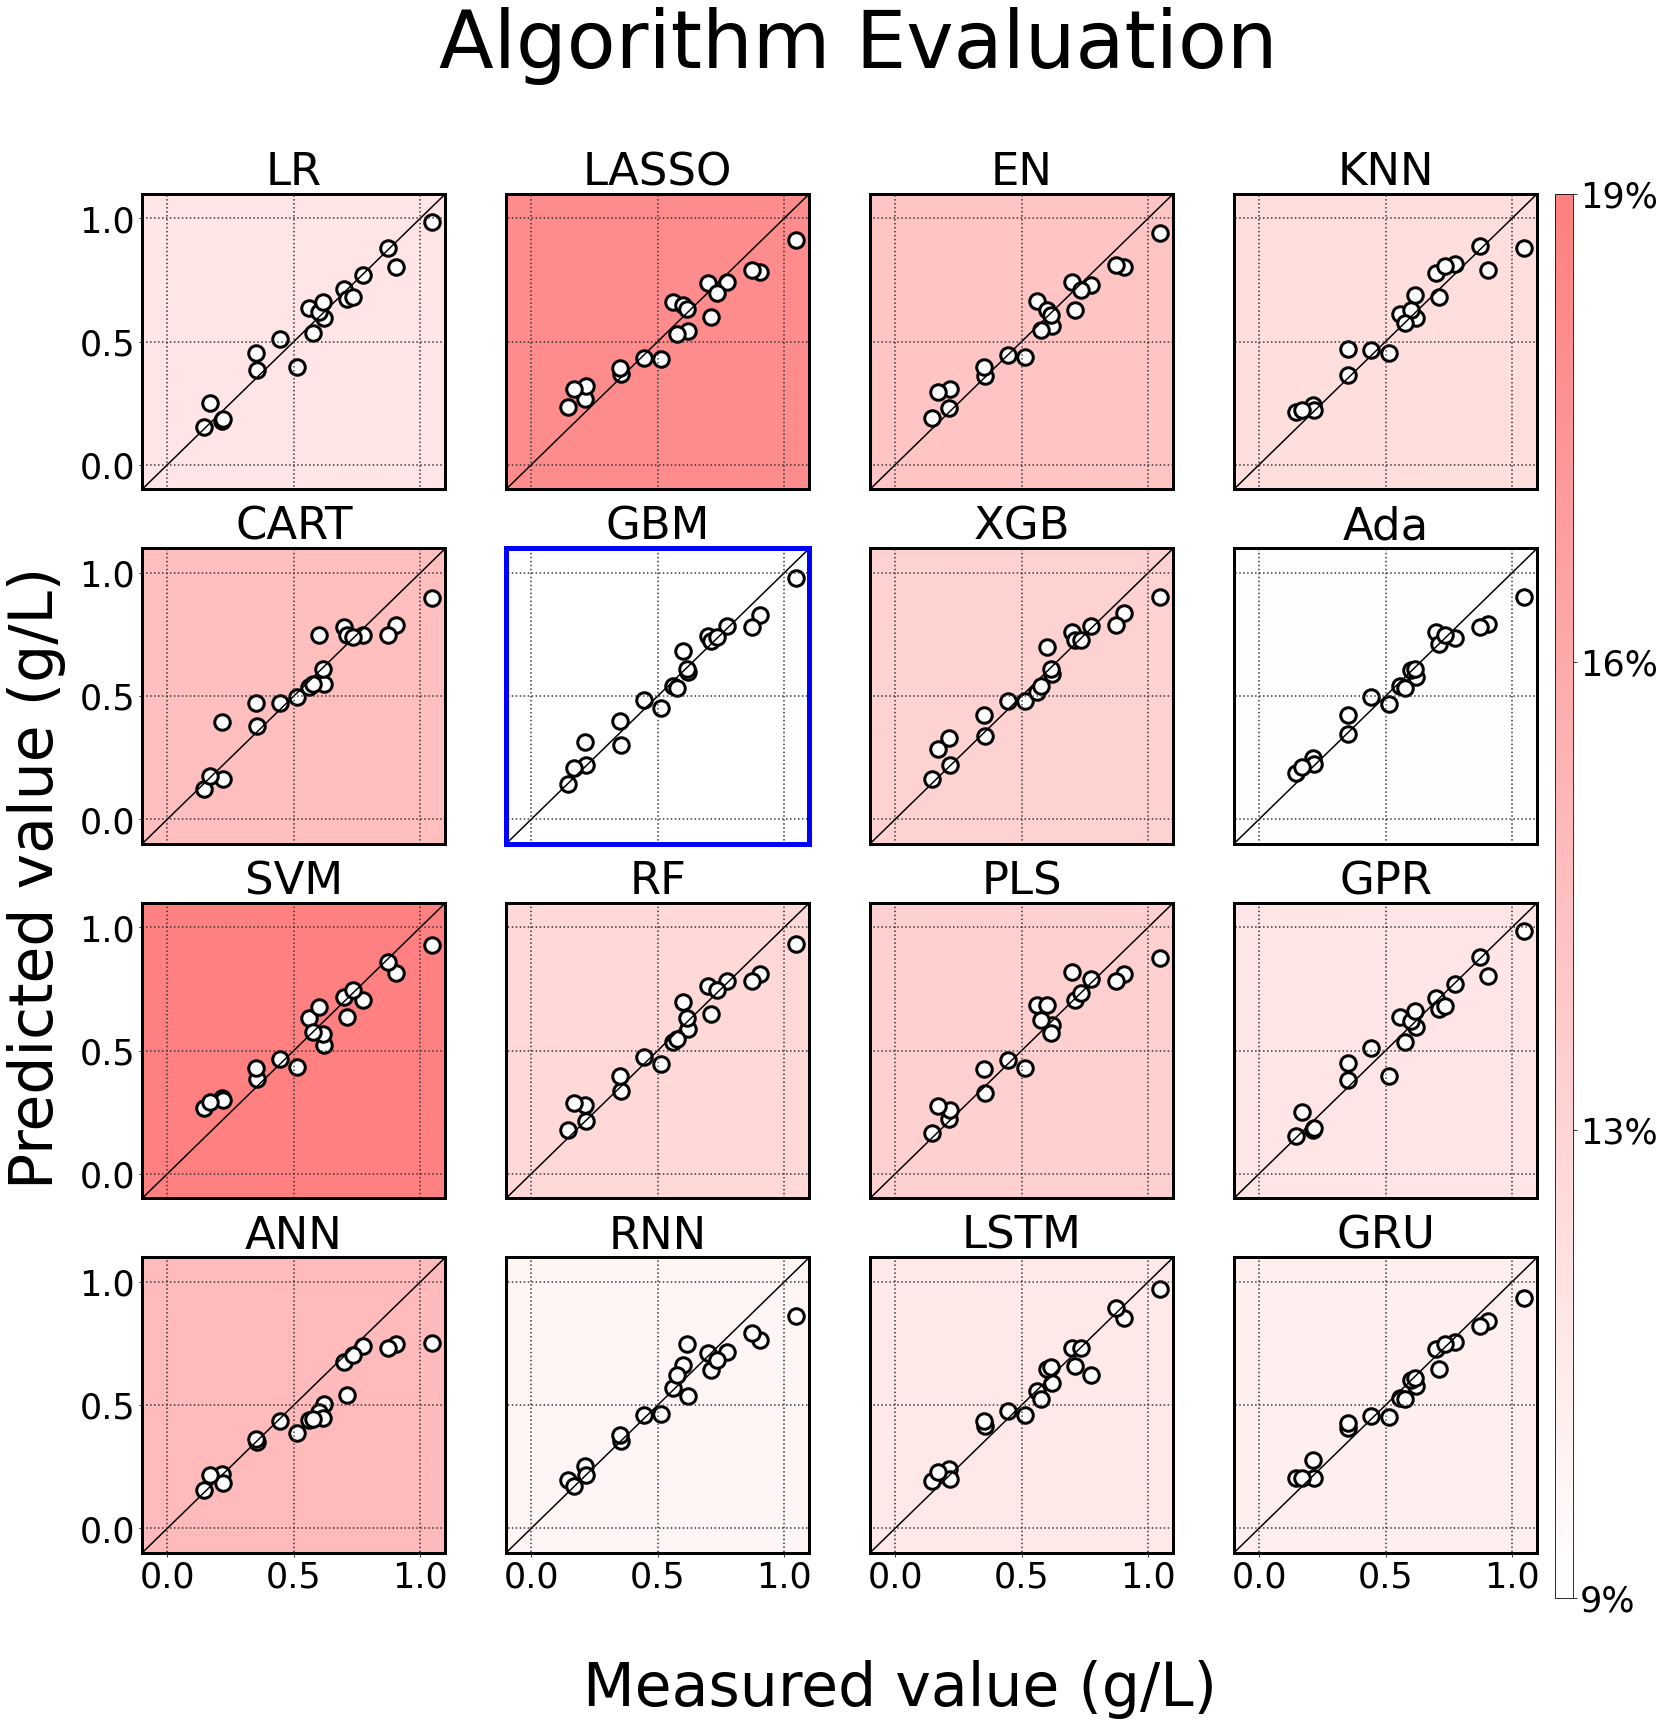

In [ ]:
model_name=np.array(["LR","LASSO","EN","KNN","CART","GBM","XGB","Ada","SVM","RF","PLS","GPR","ANN","RNN","LSTM","GRU"])
forecasting_strategy = np.array(["Recursive",'Direct','MIMO','DirRec','DIRMO'])

fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(25, 25))

for i in range(16):
  ax[i//4,i%4] = plt.subplot(4,4,i+1)
  plt.plot([-100,100],[-100,100],c='k')
  for line in ticks_list[tn]:
    plt.plot([line,line],[-100,100],':',c=(0.2,0.2,0.2))
    plt.plot([-100,100],[line,line],':',c=(0.2,0.2,0.2))
  if i in range(13):
    plt.scatter(y_test_os,Models_vcd_a[i].predict(X_test_s_os),c='w',edgecolor='k',s=240,linewidth=3)
  else:
    plt.scatter(y_test_os,Models_vcd_a[i].predict(X_test_s_rs_os),c='w',edgecolor='k',s=240,linewidth=3)
  plt.xlim(lim_list[tn])
  plt.ylim(lim_list[tn])
  plt.xticks([])
  plt.yticks([])
  plt.title(model_name[i],fontsize=45)



for i in range(4):
  plt.subplot(4,4,4*i+1)
  plt.yticks(ticks_list[tn],fontsize=35)

for i in range(4):
  plt.subplot(4,4,i+13)
  plt.xticks(ticks_list[tn],fontsize=35)

for i in range(16):
  plt.subplot(4,4,i+1)
  CRN = 0.5*(error_table_a_mape[i]-np.min(error_table_a_mape))/(np.max(error_table_a_mape)-np.min(error_table_a_mape))
  ax[i//4,i%4].patch.set_facecolor((1,1-CRN,1-CRN))

tick1 = np.min(error_table_a_mape)*100
tick2 = np.min(error_table_a_mape)*100 + (np.max(error_table_a_mape)*100-np.min(error_table_a_mape)*100)/3
tick3 = np.min(error_table_a_mape)*100 + (np.max(error_table_a_mape)*100-np.min(error_table_a_mape)*100)/3*2
tick4 = np.max(error_table_a_mape)*100
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list('my_map',[(1,1,1),(1,0.5,0.5)])
cb_ax = fig.add_axes([0.91, 0.1, 0.01, 0.78])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=CMAP),ticks=[0,1/3,2/3,1],cax=cb_ax)
cbar.set_clim(0,0.1)
cbar.ax.set_yticklabels(['%.0f' % tick1 +'%','%.0f' % tick2 +'%','%.0f' % tick3 +'%','%.0f' % tick4 +'%'])
for tick in cbar.ax.get_yticklabels():
     tick.set_fontsize(35)

for i in range(16):
  ax[i//4,i%4].spines['bottom'].set(linewidth=3)
  ax[i//4,i%4].spines['top'].set(linewidth=3)
  ax[i//4,i%4].spines['right'].set(linewidth=3)
  ax[i//4,i%4].spines['left'].set(linewidth=3)

ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['bottom'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['top'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['right'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['left'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['bottom'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['top'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['right'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['left'].set(linewidth=5)




fig.text(0.29, 0.95, 'Algorithm Evaluation',fontsize=80)
fig.text(0.37, 0.04, 'Measured value '+units[tn],fontsize=60)
fig.text(0.05, 0.5, 'Predicted value '+units[tn], va='center', rotation='vertical',fontsize=60)

model_name=np.array(["LR","LASSO","EN","KNN","CART","GBM","XGB","Ada","SVM","RF","PLS","GPR","ANN","RNN","LSTM","GRU"])
forecasting_strategy = np.array(["Recursive",'Direct','MIMO','DirRec','DIRMO'])

fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(25, 25))

for i in range(16):
  ax[i//4,i%4] = plt.subplot(4,4,i+1)
  plt.plot([-100,100],[-100,100],c='k')
  for line in ticks_list[tn]:
    plt.plot([line,line],[-100,100],':',c=(0.2,0.2,0.2))
    plt.plot([-100,100],[line,line],':',c=(0.2,0.2,0.2))
  if i in range(13):
    plt.scatter(y_test_os,Models_vcd_a[i].predict(X_test_s_os),c='w',edgecolor='k',s=240,linewidth=3)
  else:
    plt.scatter(y_test_os,Models_vcd_a[i].predict(X_test_s_rs_os),c='w',edgecolor='k',s=240,linewidth=3)
  plt.xlim(lim_list[tn])
  plt.ylim(lim_list[tn])
  plt.xticks([])
  plt.yticks([])
  plt.title(model_name[i],fontsize=45)



for i in range(4):
  plt.subplot(4,4,4*i+1)
  plt.yticks(ticks_list[tn],fontsize=35)

for i in range(4):
  plt.subplot(4,4,i+13)
  plt.xticks(ticks_list[tn],fontsize=35)

for i in range(16):
  plt.subplot(4,4,i+1)
  CRN = 0.5*(error_table_a_mape[i]-np.min(error_table_a_mape))/(np.max(error_table_a_mape)-np.min(error_table_a_mape))
  ax[i//4,i%4].patch.set_facecolor((1,1-CRN,1-CRN))

tick1 = np.min(error_table_a_mape)*100
tick2 = np.min(error_table_a_mape)*100 + (np.max(error_table_a_mape)*100-np.min(error_table_a_mape)*100)/3
tick3 = np.min(error_table_a_mape)*100 + (np.max(error_table_a_mape)*100-np.min(error_table_a_mape)*100)/3*2
tick4 = np.max(error_table_a_mape)*100
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list('my_map',[(1,1,1),(1,0.5,0.5)])
cb_ax = fig.add_axes([0.91, 0.1, 0.01, 0.78])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=CMAP),ticks=[0,1/3,2/3,1],cax=cb_ax)
cbar.set_clim(0,0.1)
cbar.ax.set_yticklabels(['%.0f' % tick1 +'%','%.0f' % tick2 +'%','%.0f' % tick3 +'%','%.0f' % tick4 +'%'])
for tick in cbar.ax.get_yticklabels():
     tick.set_fontsize(35)

for i in range(16):
  ax[i//4,i%4].spines['bottom'].set(linewidth=3)
  ax[i//4,i%4].spines['top'].set(linewidth=3)
  ax[i//4,i%4].spines['right'].set(linewidth=3)
  ax[i//4,i%4].spines['left'].set(linewidth=3)

ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['bottom'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['top'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['right'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['left'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['bottom'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['top'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['right'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['left'].set(linewidth=5)




fig.text(0.29, 0.95, 'Algorithm Evaluation',fontsize=80)
fig.text(0.37, 0.04, 'Measured value '+units[tn],fontsize=60)
fig.text(0.05, 0.5, 'Predicted value '+units[tn], va='center', rotation='vertical',fontsize=60)

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 27ms/step


Text(0.05, 0.5, 'Predicted value (g/L)')

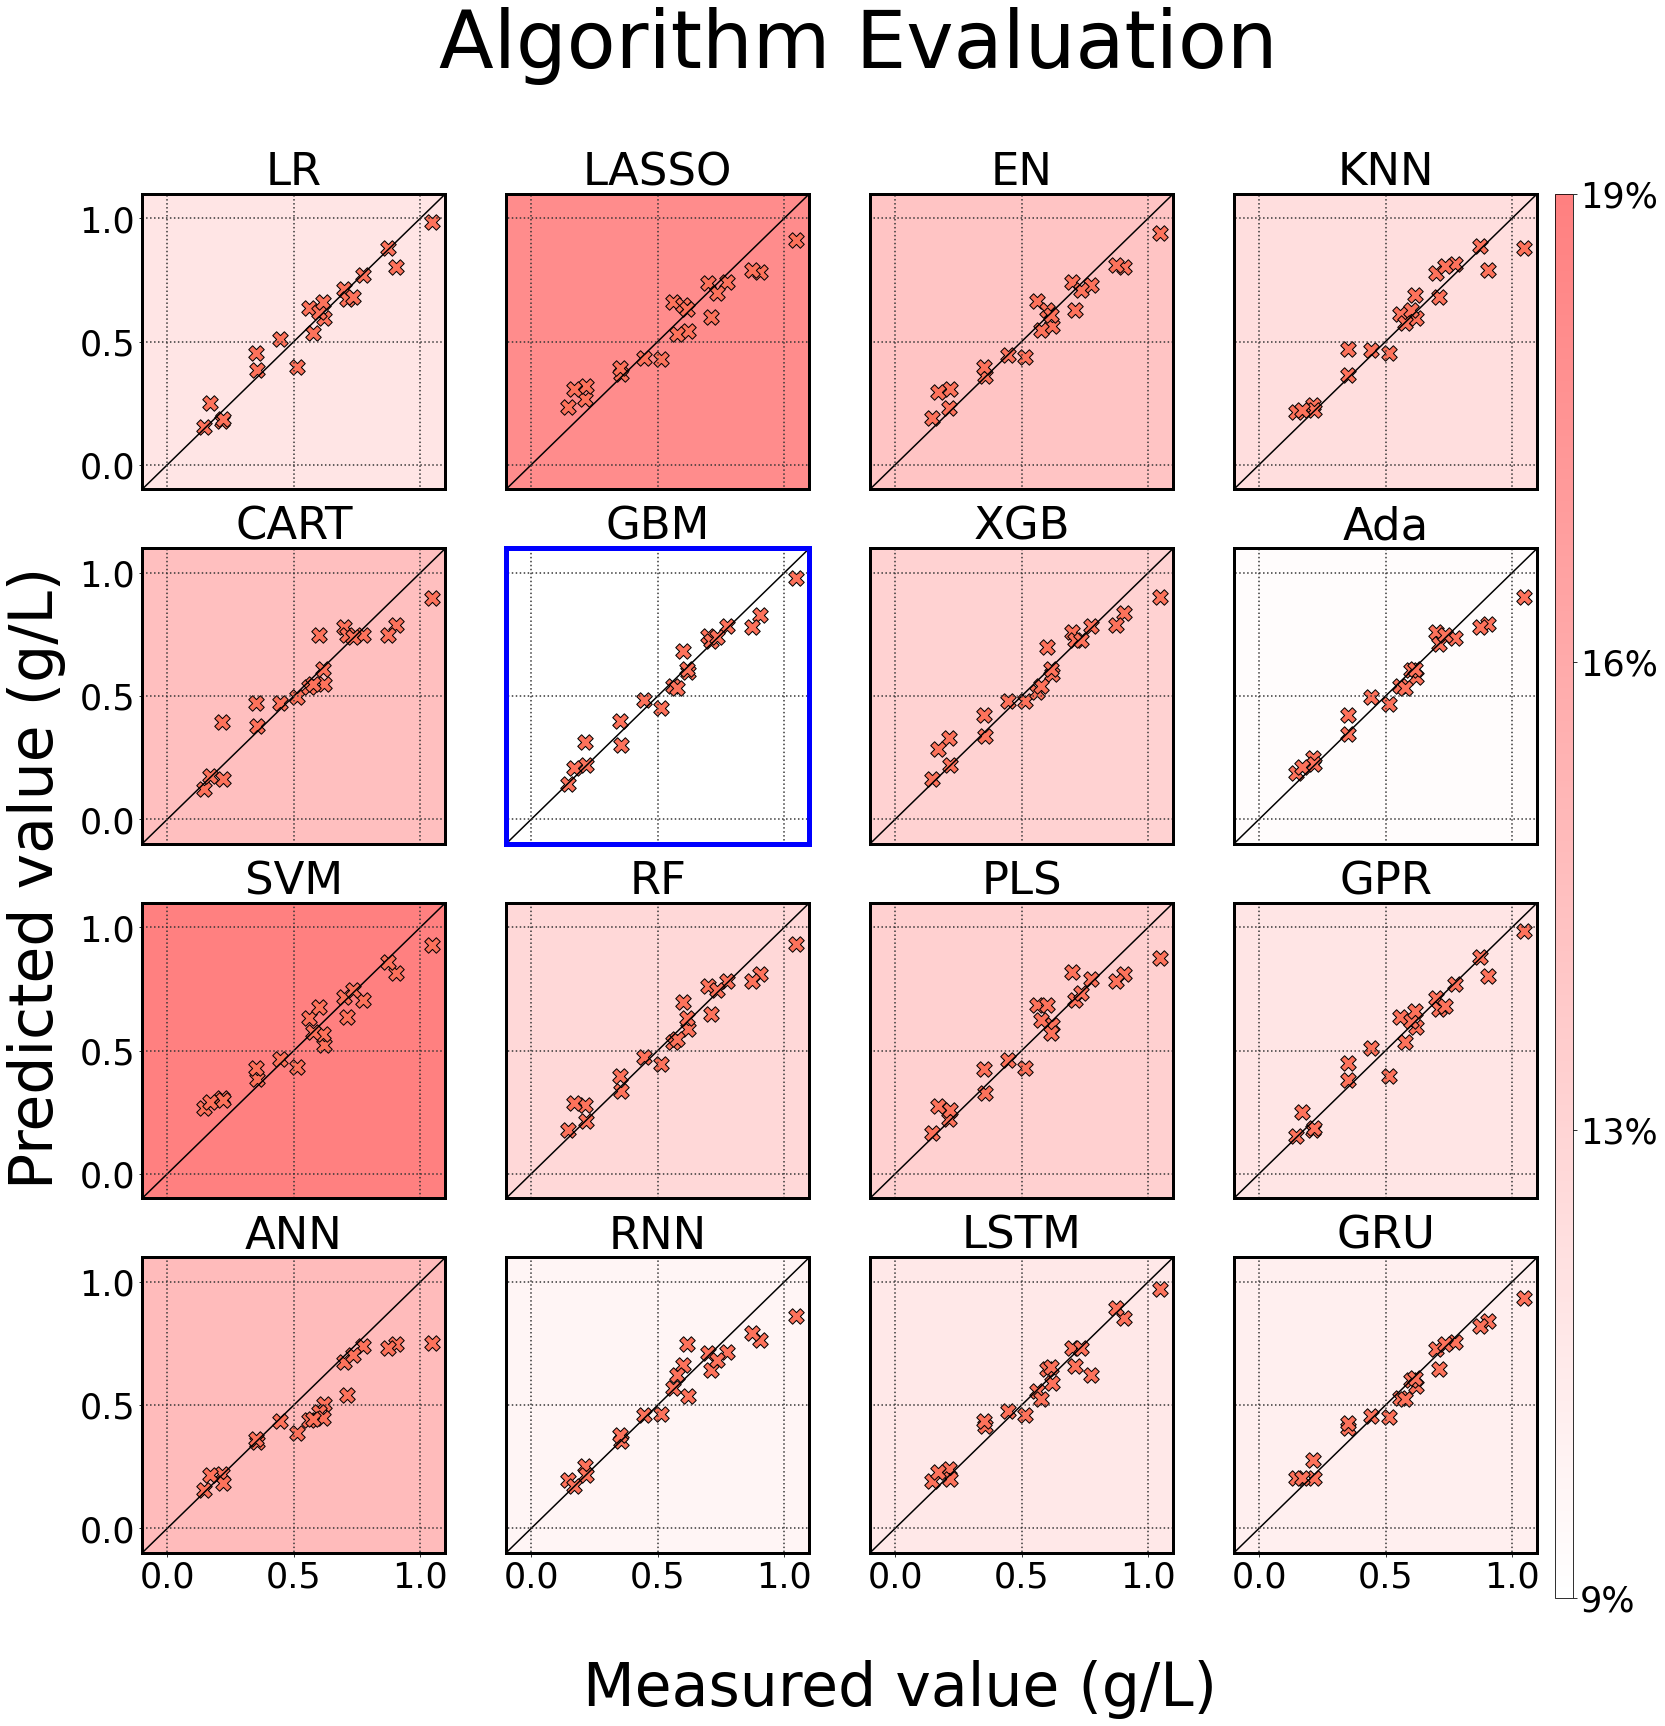

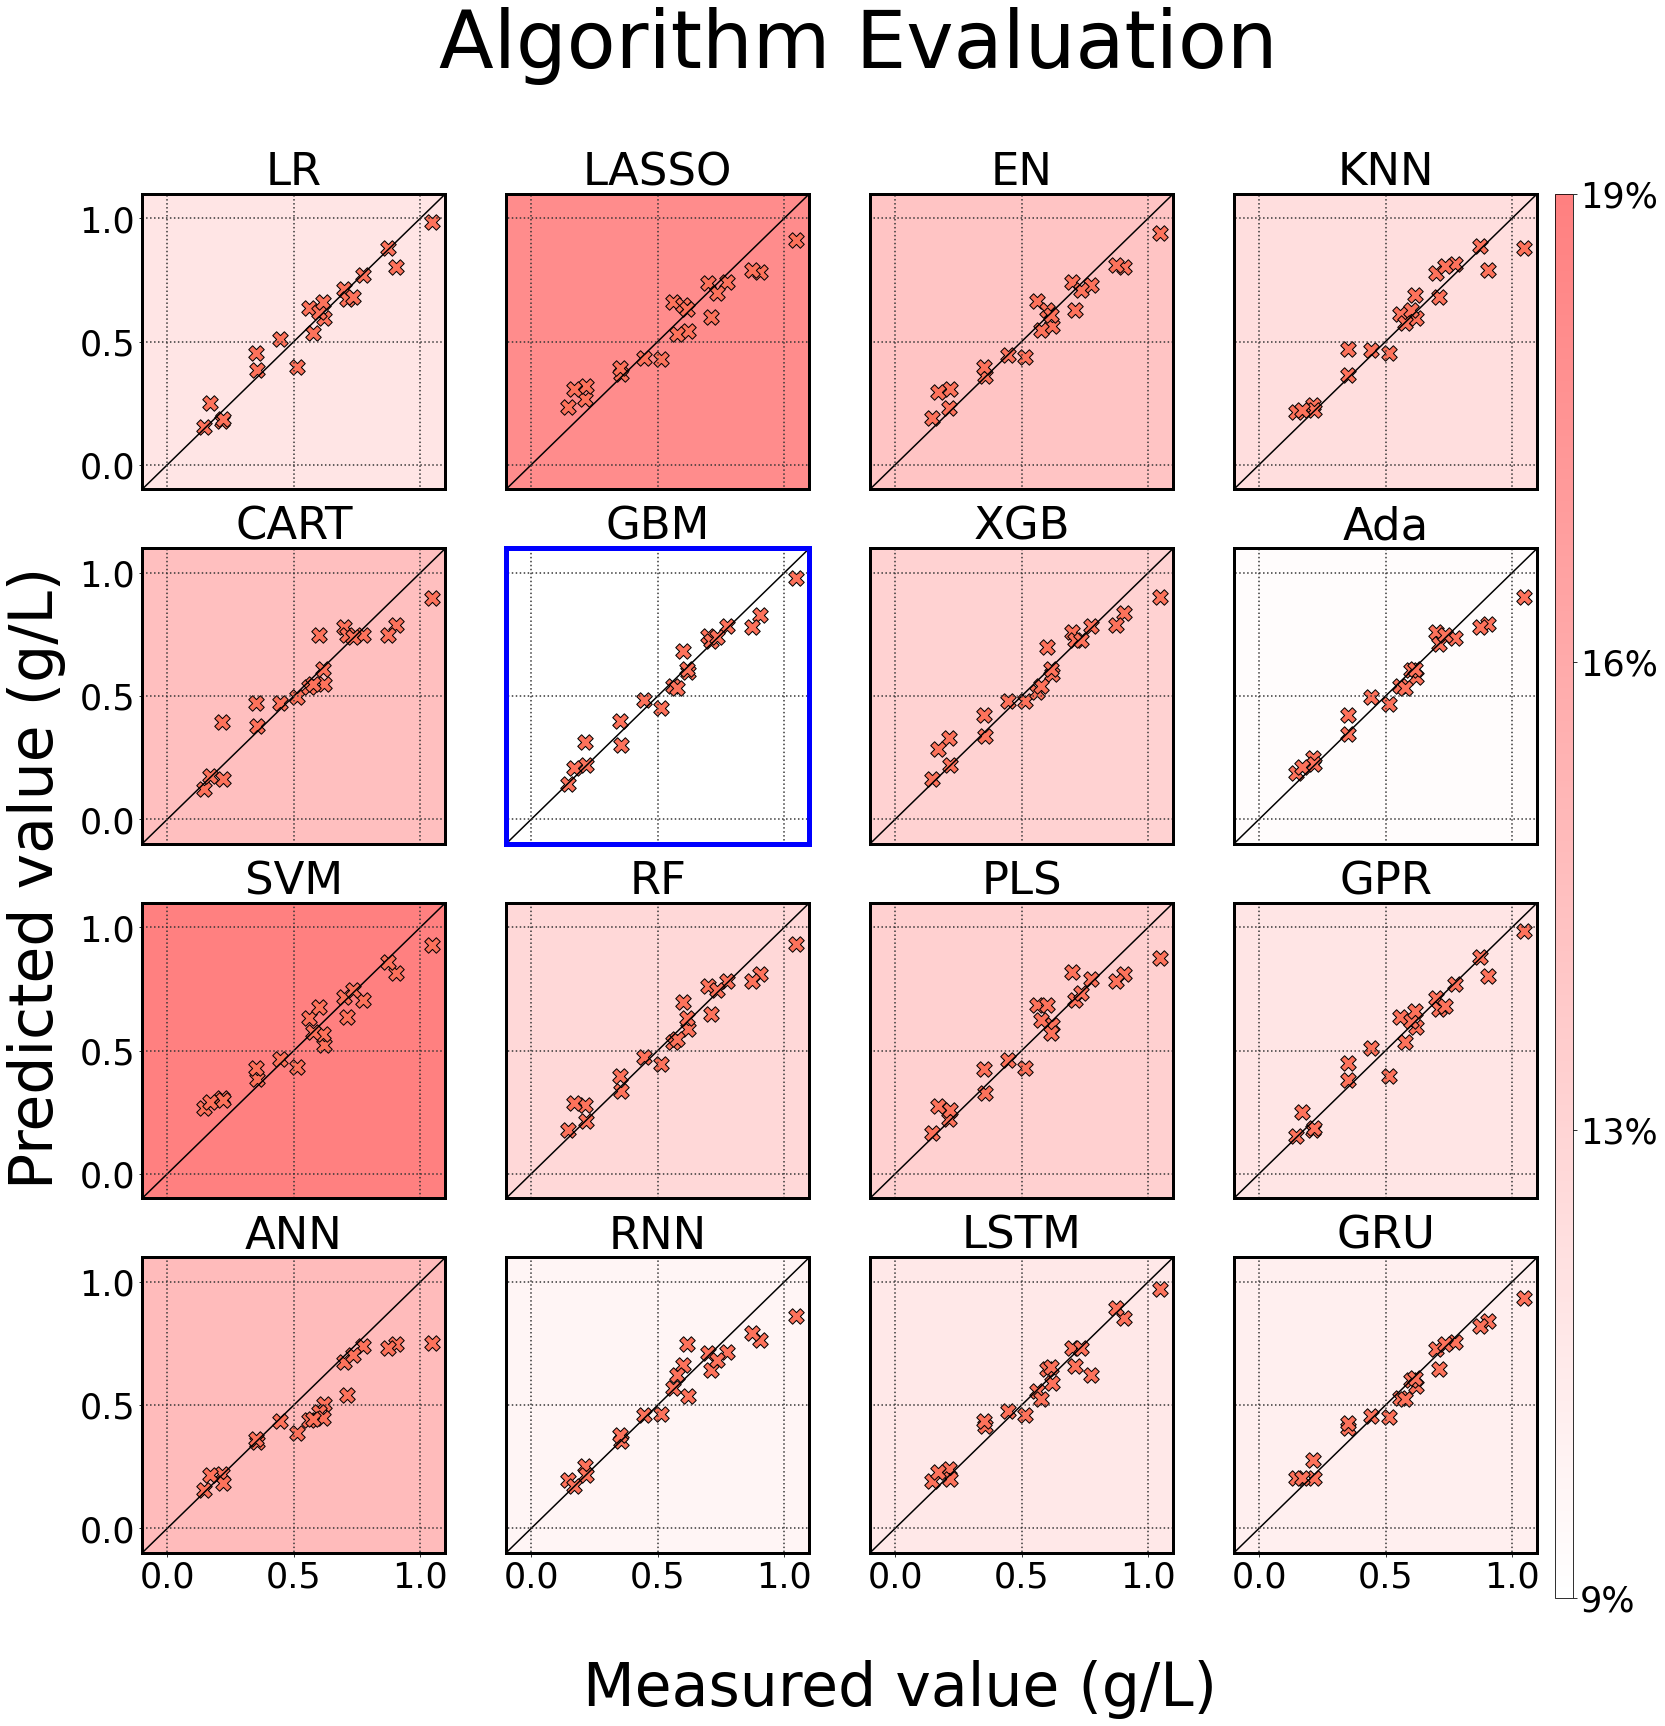

In [ ]:


model_name=np.array(["LR","LASSO","EN","KNN","CART","GBM","XGB","Ada","SVM","RF","PLS","GPR","ANN","RNN","LSTM","GRU"])
forecasting_strategy = np.array(["Recursive",'Direct','MIMO','DirRec','DIRMO'])

fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(25, 25))

for i in range(16):
  ax[i//4,i%4] = plt.subplot(4,4,i+1)
  plt.plot([-100,100],[-100,100],c='k')
  for line in ticks_list[tn]:
    plt.plot([line,line],[-100,100],':',c=(0.2,0.2,0.2))
    plt.plot([-100,100],[line,line],':',c=(0.2,0.2,0.2))
  if i in range(13):
    plt.scatter(y_test_os,Models_vcd_a[i].predict(X_test_s_os),c=(0.9941,0.4463,0.3580),marker='X',edgecolor='k',s=240,linewidth=1)
  else:
    plt.scatter(y_test_os,Models_vcd_a[i].predict(X_test_s_rs_os),c=(0.9941,0.4463,0.3580),marker='X',edgecolor='k',s=240,linewidth=1)
  plt.xlim(lim_list[tn])
  plt.ylim(lim_list[tn])
  plt.xticks([])
  plt.yticks([])
  plt.title(model_name[i],fontsize=45)



for i in range(4):
  plt.subplot(4,4,4*i+1)
  plt.yticks(ticks_list[tn],fontsize=35)

for i in range(4):
  plt.subplot(4,4,i+13)
  plt.xticks(ticks_list[tn],fontsize=35)

for i in range(16):
  plt.subplot(4,4,i+1)
  CRN = 0.5*(error_table_a_mape[i]-np.min(error_table_a_mape))/(np.max(error_table_a_mape)-np.min(error_table_a_mape))
  ax[i//4,i%4].patch.set_facecolor((1,1-CRN,1-CRN))

tick1 = np.min(error_table_a_mape)*100
tick2 = np.min(error_table_a_mape)*100 + (np.max(error_table_a_mape)*100-np.min(error_table_a_mape)*100)/3
tick3 = np.min(error_table_a_mape)*100 + (np.max(error_table_a_mape)*100-np.min(error_table_a_mape)*100)/3*2
tick4 = np.max(error_table_a_mape)*100
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list('my_map',[(1,1,1),(1,0.5,0.5)])
cb_ax = fig.add_axes([0.91, 0.1, 0.01, 0.78])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=CMAP),ticks=[0,1/3,2/3,1],cax=cb_ax)
cbar.set_clim(0,0.1)
cbar.ax.set_yticklabels(['%.0f' % tick1 +'%','%.0f' % tick2 +'%','%.0f' % tick3 +'%','%.0f' % tick4 +'%'])
for tick in cbar.ax.get_yticklabels():
     tick.set_fontsize(35)

for i in range(16):
  ax[i//4,i%4].spines['bottom'].set(linewidth=3)
  ax[i//4,i%4].spines['top'].set(linewidth=3)
  ax[i//4,i%4].spines['right'].set(linewidth=3)
  ax[i//4,i%4].spines['left'].set(linewidth=3)

ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['bottom'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['top'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['right'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['left'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['bottom'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['top'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['right'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['left'].set(linewidth=5)




fig.text(0.29, 0.95, 'Algorithm Evaluation',fontsize=80)
fig.text(0.37, 0.04, 'Measured value '+units[tn],fontsize=60)
fig.text(0.05, 0.5, 'Predicted value '+units[tn], va='center', rotation='vertical',fontsize=60)



model_name=np.array(["LR","LASSO","EN","KNN","CART","GBM","XGB","Ada","SVM","RF","PLS","GPR","ANN","RNN","LSTM","GRU"])
forecasting_strategy = np.array(["Recursive",'Direct','MIMO','DirRec','DIRMO'])

fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(25, 25))

for i in range(16):
  ax[i//4,i%4] = plt.subplot(4,4,i+1)
  plt.plot([-100,100],[-100,100],c='k')
  for line in ticks_list[tn]:
    plt.plot([line,line],[-100,100],':',c=(0.2,0.2,0.2))
    plt.plot([-100,100],[line,line],':',c=(0.2,0.2,0.2))
  if i in range(13):
    plt.scatter(y_test_os,Models_vcd_a[i].predict(X_test_s_os),c=(0.9941,0.4463,0.3580),marker='X',edgecolor='k',s=240,linewidth=1)
  else:
    plt.scatter(y_test_os,Models_vcd_a[i].predict(X_test_s_rs_os),c=(0.9941,0.4463,0.3580),marker='X',edgecolor='k',s=240,linewidth=1)
  plt.xlim(lim_list[tn])
  plt.ylim(lim_list[tn])
  plt.xticks([])
  plt.yticks([])
  plt.title(model_name[i],fontsize=45)



for i in range(4):
  plt.subplot(4,4,4*i+1)
  plt.yticks(ticks_list[tn],fontsize=35)

for i in range(4):
  plt.subplot(4,4,i+13)
  plt.xticks(ticks_list[tn],fontsize=35)

for i in range(16):
  plt.subplot(4,4,i+1)
  CRN = 0.5*(error_table_a_mape[i]-np.min(error_table_a_mape))/(np.max(error_table_a_mape)-np.min(error_table_a_mape))
  ax[i//4,i%4].patch.set_facecolor((1,1-CRN,1-CRN))

tick1 = np.min(error_table_a_mape)*100
tick2 = np.min(error_table_a_mape)*100 + (np.max(error_table_a_mape)*100-np.min(error_table_a_mape)*100)/3
tick3 = np.min(error_table_a_mape)*100 + (np.max(error_table_a_mape)*100-np.min(error_table_a_mape)*100)/3*2
tick4 = np.max(error_table_a_mape)*100
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list('my_map',[(1,1,1),(1,0.5,0.5)])
cb_ax = fig.add_axes([0.91, 0.1, 0.01, 0.78])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=CMAP),ticks=[0,1/3,2/3,1],cax=cb_ax)
cbar.set_clim(0,0.1)
cbar.ax.set_yticklabels(['%.0f' % tick1 +'%','%.0f' % tick2 +'%','%.0f' % tick3 +'%','%.0f' % tick4 +'%'])
for tick in cbar.ax.get_yticklabels():
     tick.set_fontsize(35)

for i in range(16):
  ax[i//4,i%4].spines['bottom'].set(linewidth=3)
  ax[i//4,i%4].spines['top'].set(linewidth=3)
  ax[i//4,i%4].spines['right'].set(linewidth=3)
  ax[i//4,i%4].spines['left'].set(linewidth=3)

ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['bottom'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['top'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['right'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['left'].set_color((0,0,1))
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['bottom'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['top'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['right'].set(linewidth=5)
ax[error_table_a_mape.index(min(error_table_a_mape))//4,error_table_a_mape.index(min(error_table_a_mape))%4].spines['left'].set(linewidth=5)




fig.text(0.29, 0.95, 'Algorithm Evaluation',fontsize=80)
fig.text(0.37, 0.04, 'Measured value '+units[tn],fontsize=60)
fig.text(0.05, 0.5, 'Predicted value '+units[tn], va='center', rotation='vertical',fontsize=60)

(3, 4, 5)
(3, 4, 5)


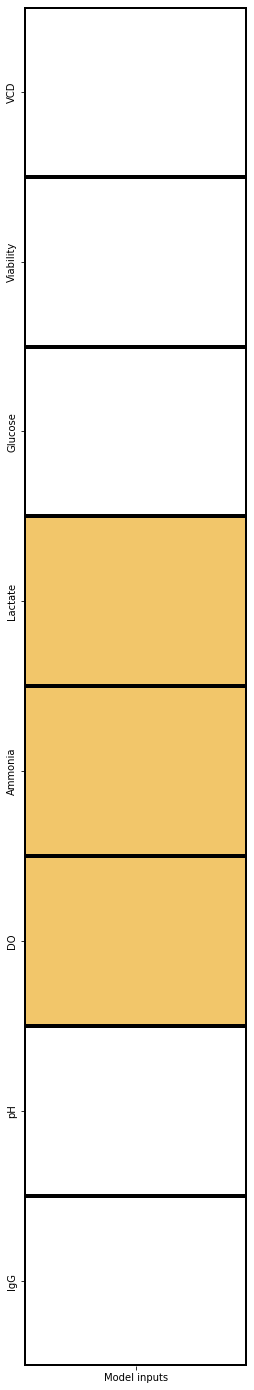

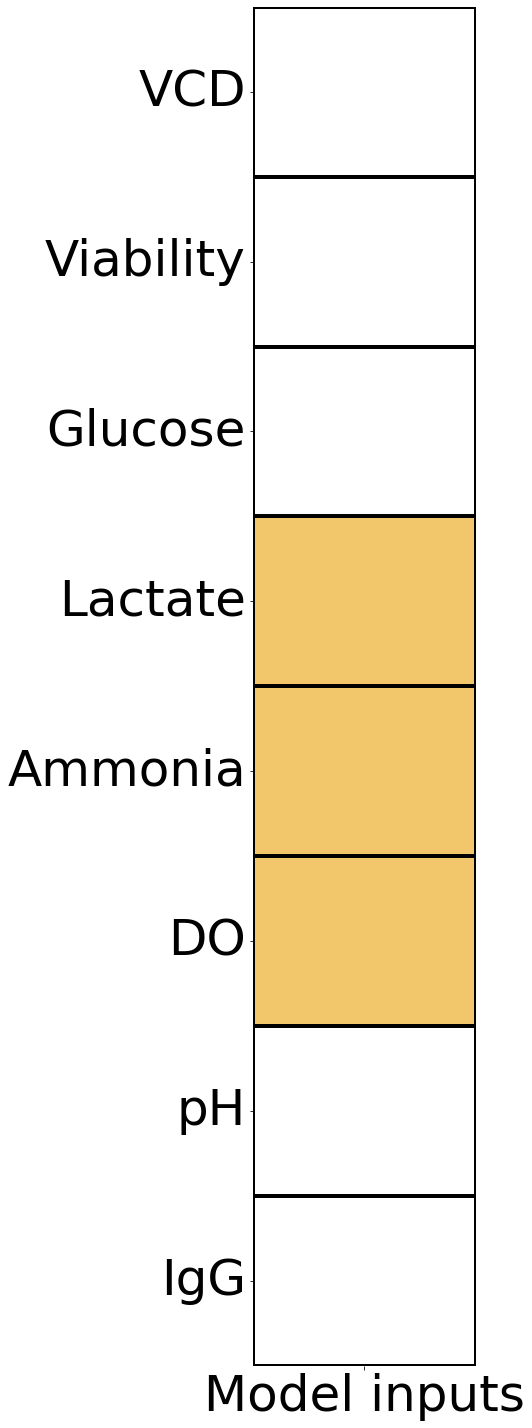

In [ ]:
print(best_error_vcd_com)
input_names = ['VCD','Viability','Glucose','Lactate','Ammonia','DO','pH','IgG']
hmap = np.zeros((8,1))
for i in best_error_vcd_com:
  hmap[i,0] = 1
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(4, 25))
plt.rc('font',size=50)
CMAP1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_map',[(1,1,1),(0.9490,0.7773,0.4157)])
sns.heatmap(hmap,cbar=False,linewidths=3, linecolor='k',cmap=CMAP1,yticklabels=input_names,xticklabels=['Model inputs'])

print(best_error_vcd_com)
input_names = ['VCD','Viability','Glucose','Lactate','Ammonia','DO','pH','IgG']
hmap = np.zeros((8,1))
for i in best_error_vcd_com:
  hmap[i,0] = 1
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(4, 25))
plt.rc('font',size=50)
CMAP1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_map',[(1,1,1),(0.9490,0.7773,0.4157)])
sns.heatmap(hmap,cbar=False,linewidths=3, linecolor='k',cmap=CMAP1,yticklabels=input_names,xticklabels=['Model inputs'])

[None]

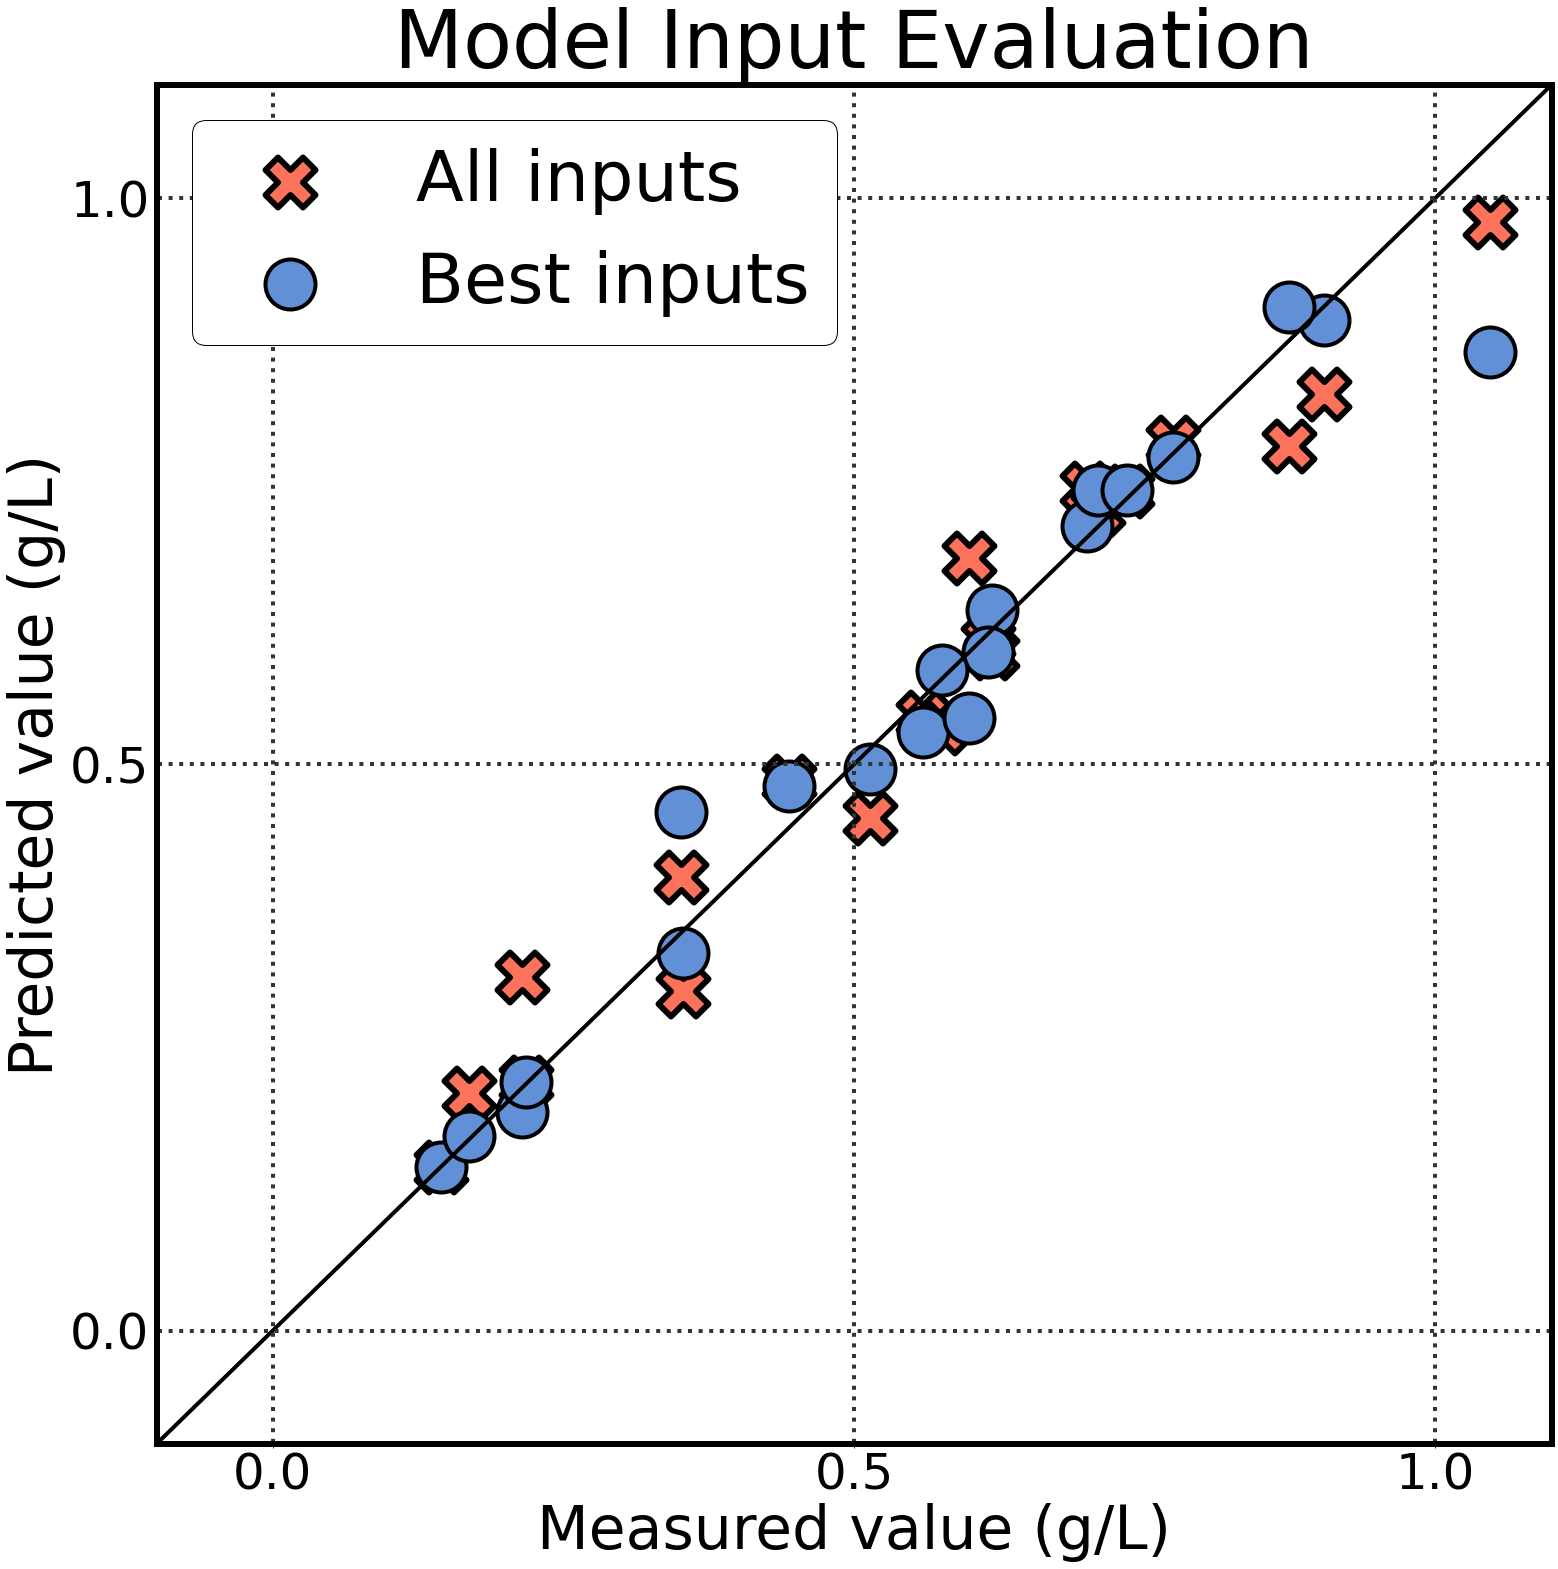

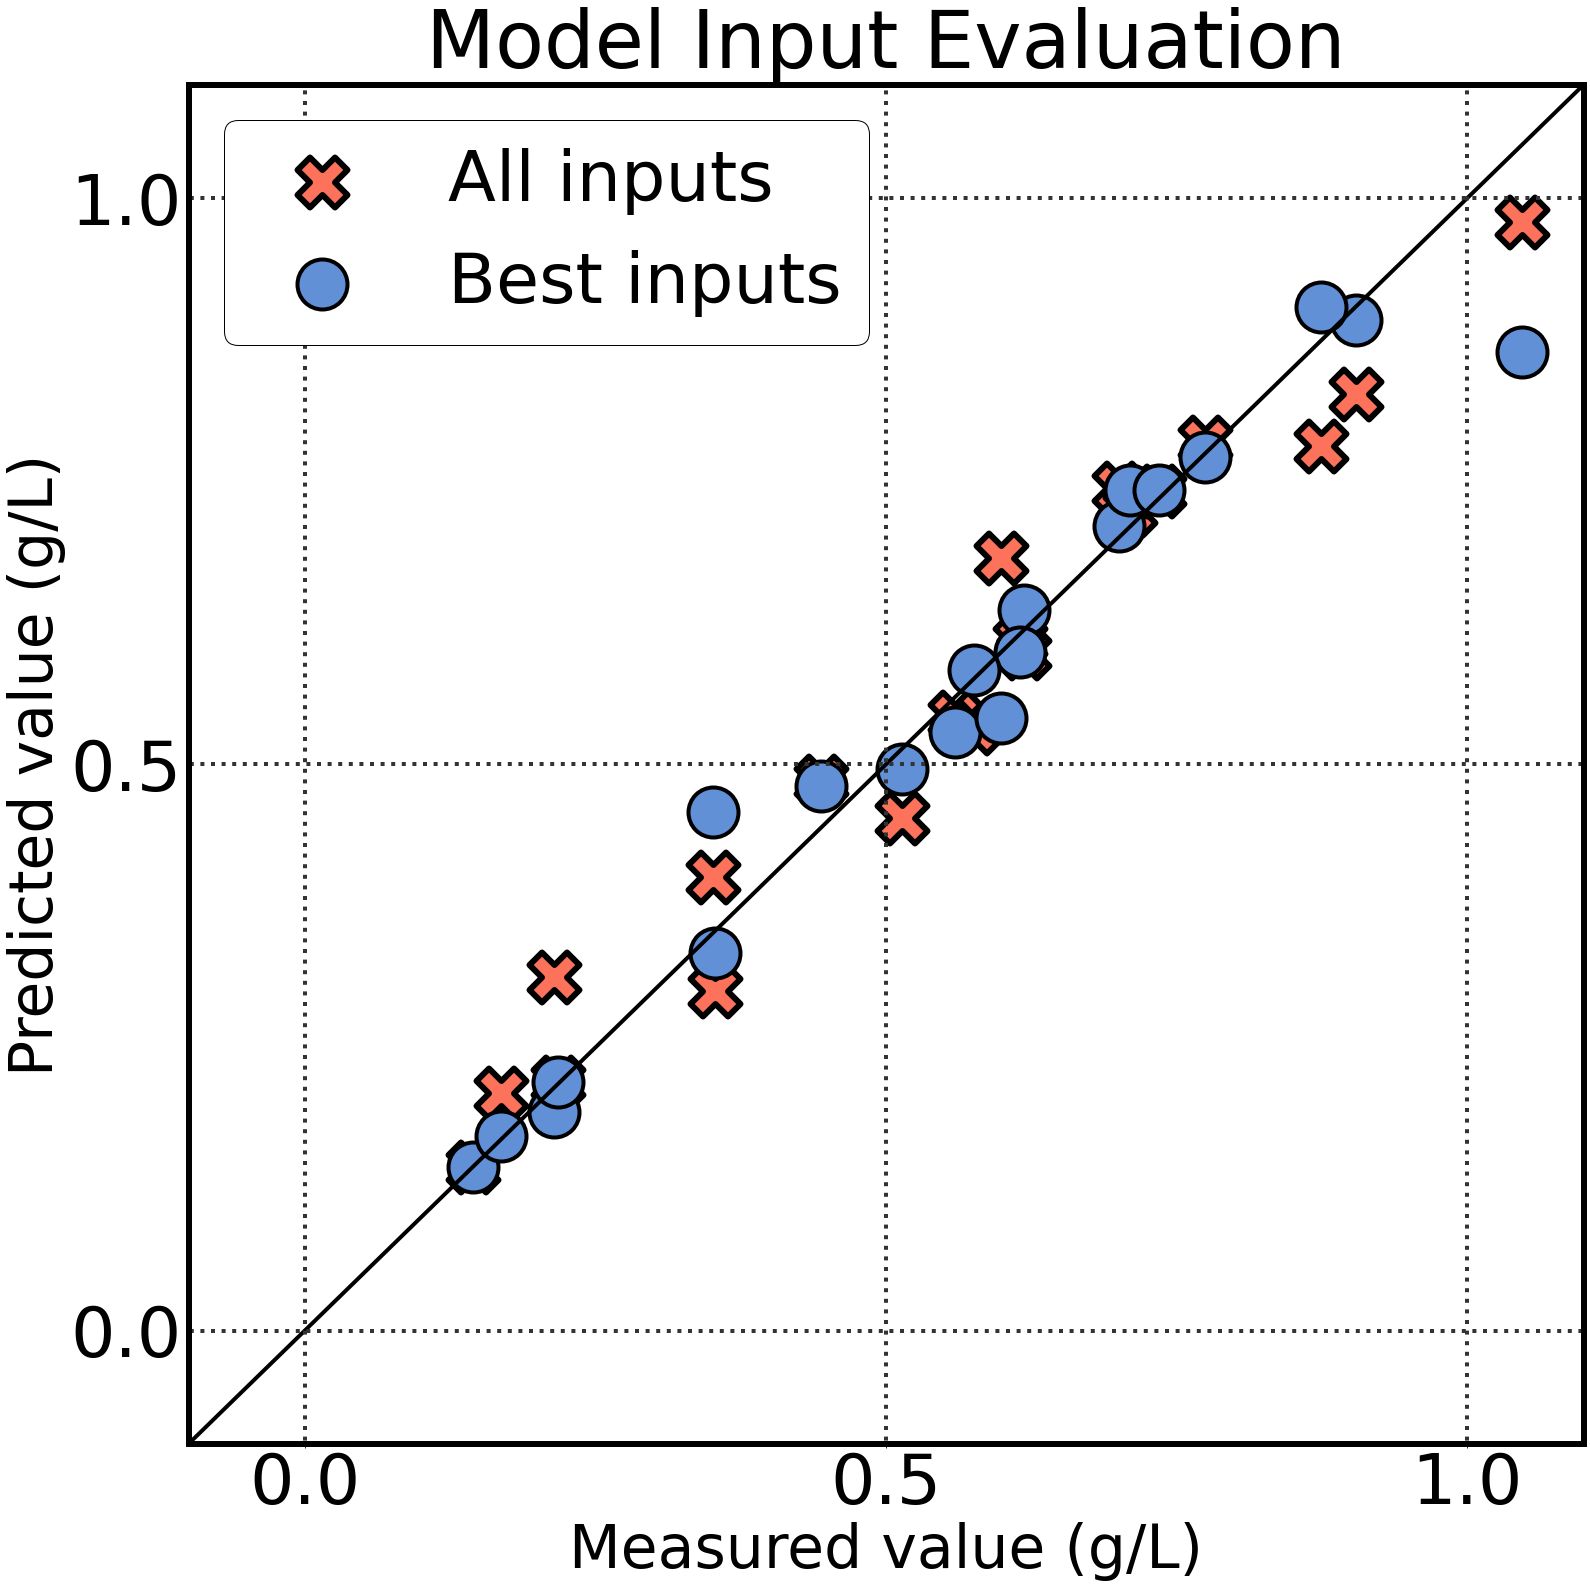

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(25, 25))

plt.plot([-100,100],[-100,100],c='k',linewidth=4)
for line in ticks_list[tn]:
  plt.plot([line,line],[-100,100],':',c=(0.2,0.2,0.2),linewidth=4)
  plt.plot([-100,100],[line,line],':',c=(0.2,0.2,0.2),linewidth=4)
if best_algorithm_no in range(12):
  plt.scatter(y_test_os,Models_vcd_a[best_algorithm_no].predict(X_test_s_os),c=(0.9941,0.4463,0.3580),marker='X',edgecolor='k',linewidth=6,s=2500,label='All inputs')
else:
  plt.scatter(y_test_os,Models_vcd_a[best_algorithm_no].predict(X_test_s_rs_os),c='none',edgecolor='k',linewidth=6,s=2500,label='All inputs')
plt.scatter(y_test_os,best_error_vcd_model.predict(best_error_vcd_X),c=(0.3827,0.5663,0.8447),edgecolor='k',linewidth=4,s=2500,label='Best inputs')
plt.xlim(lim_list[tn])
plt.ylim(lim_list[tn])
plt.xticks(ticks_list[tn])
plt.yticks(ticks_list[tn])
plt.rc('font',size=70)
plt.legend(facecolor='w',framealpha=1,edgecolor='k')
plt.title("Model Input Evaluation",fontsize=80)
plt.xlabel('Measured value '+units[tn],fontsize=60)
plt.ylabel('Predicted value '+units[tn],fontsize=60)

ax.spines['bottom'].set(linewidth=6)
ax.spines['top'].set(linewidth=6)
ax.spines['right'].set(linewidth=6)
ax.spines['left'].set(linewidth=6)

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(25, 25))

plt.plot([-100,100],[-100,100],c='k',linewidth=4)
for line in ticks_list[tn]:
  plt.plot([line,line],[-100,100],':',c=(0.2,0.2,0.2),linewidth=4)
  plt.plot([-100,100],[line,line],':',c=(0.2,0.2,0.2),linewidth=4)
if best_algorithm_no in range(12):
  plt.scatter(y_test_os,Models_vcd_a[best_algorithm_no].predict(X_test_s_os),c=(0.9941,0.4463,0.3580),marker='X',edgecolor='k',linewidth=6,s=2500,label='All inputs')
else:
  plt.scatter(y_test_os,Models_vcd_a[best_algorithm_no].predict(X_test_s_rs_os),c='none',edgecolor='k',linewidth=6,s=2500,label='All inputs')
plt.scatter(y_test_os,best_error_vcd_model.predict(best_error_vcd_X),c=(0.3827,0.5663,0.8447),edgecolor='k',linewidth=4,s=2500,label='Best inputs')
plt.xlim(lim_list[tn])
plt.ylim(lim_list[tn])
plt.xticks(ticks_list[tn])
plt.yticks(ticks_list[tn])
plt.rc('font',size=70)
plt.legend(facecolor='w',framealpha=1,edgecolor='k')
plt.title("Model Input Evaluation",fontsize=80)
plt.xlabel('Measured value '+units[tn],fontsize=60)
plt.ylabel('Predicted value '+units[tn],fontsize=60)

ax.spines['bottom'].set(linewidth=6)
ax.spines['top'].set(linewidth=6)
ax.spines['right'].set(linewidth=6)
ax.spines['left'].set(linewidth=6)

Text(0.07, 0.5, 'Predicted value (g/L)')

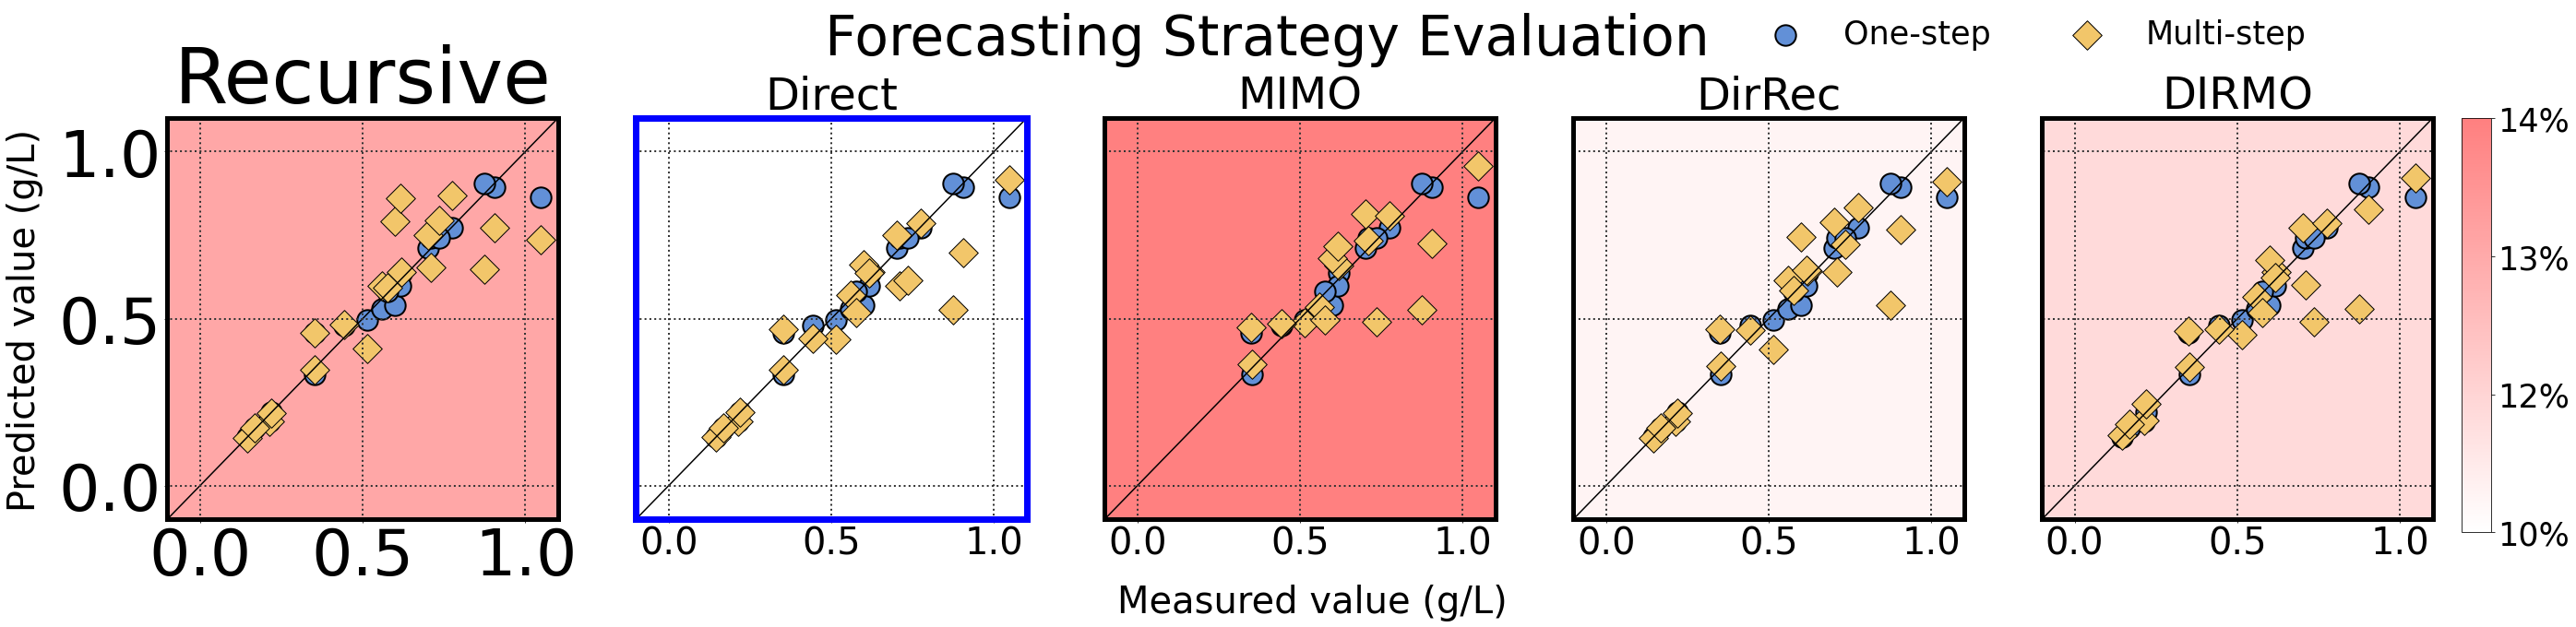

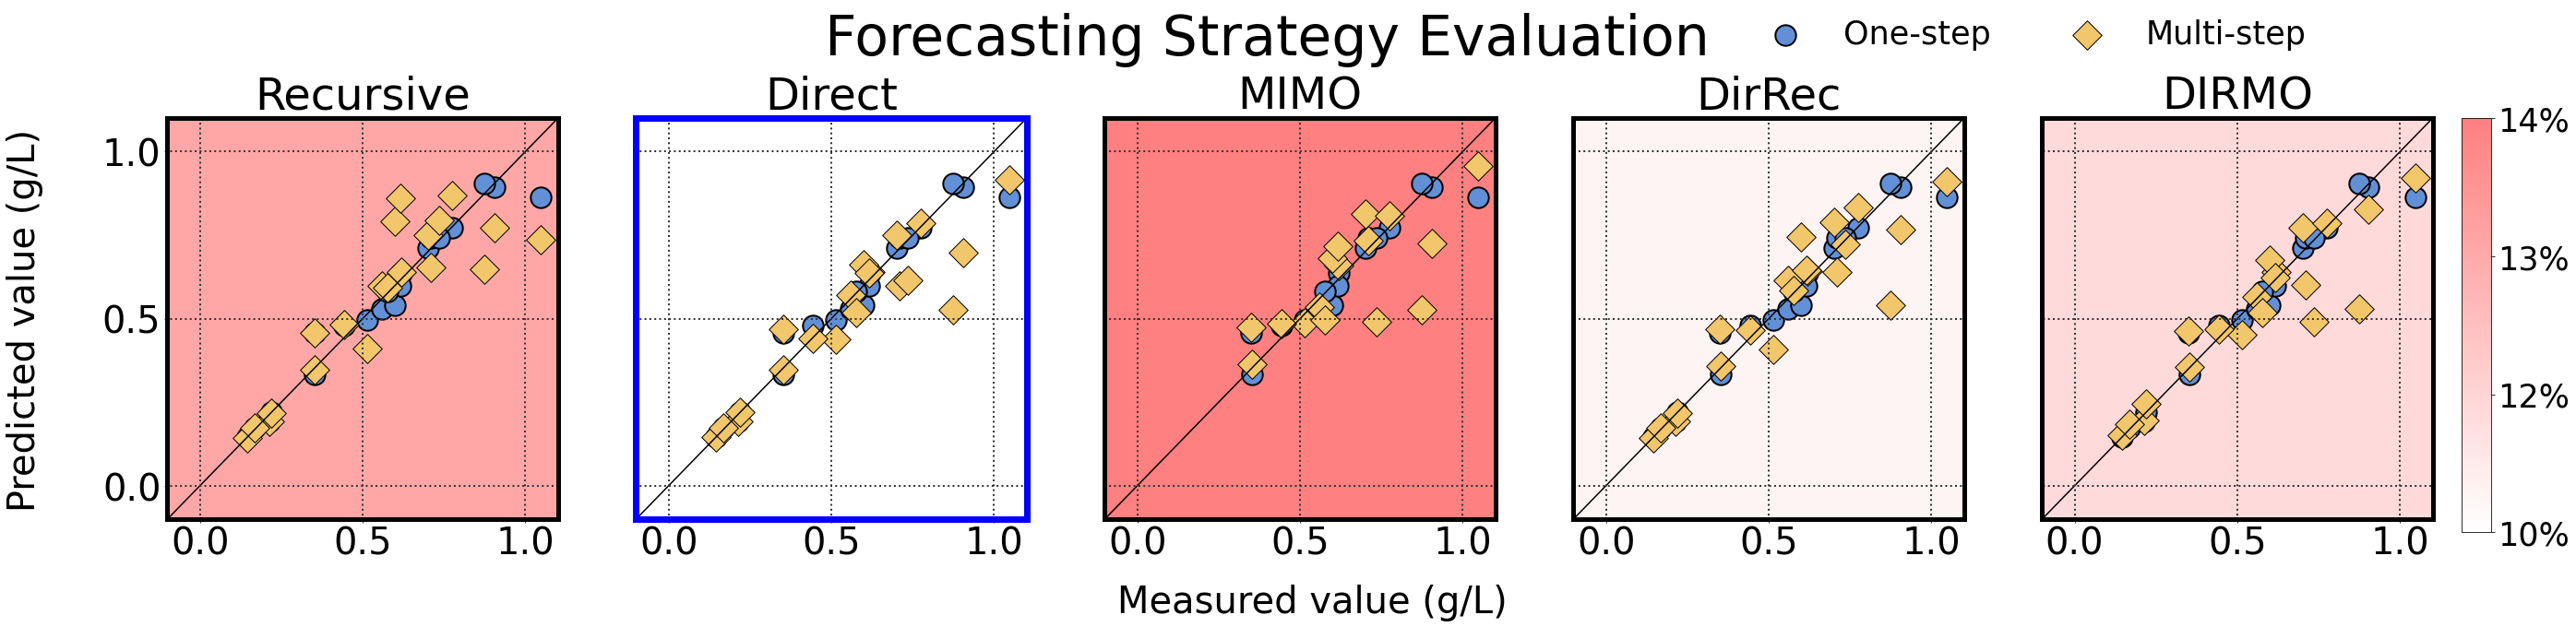

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(44, 8))

for i in range(5):
  ax[i] = plt.subplot(1,5,i+1)
  plt.scatter(y_test_trajectory[i],y_pred_os_trajectory[i],c=(0.3827,0.5663,0.8447),edgecolor='k',linewidth=2,s=500,label='One-step')
  plt.scatter(y_test_trajectory[i],y_pred_ms_trajectory[i],c=(0.9490,0.7773,0.4157),marker="D",edgecolor='k',s=500,label='Multi-step')
  plt.plot([-100,100],[-100,100],c='k')
  for line in ticks_list[tn]:
    plt.plot([line,line],[-100,100],':',c=(0.2,0.2,0.2),linewidth=2)
    plt.plot([-100,100],[line,line],':',c=(0.2,0.2,0.2),linewidth=2)
  plt.xlim(lim_list[tn])
  plt.ylim(lim_list[tn])
  plt.xticks(ticks_list[tn])
  plt.yticks([])
  if i == 0:
    plt.yticks(ticks_list[tn])
  plt.title(forecasting_strategy[i])
  plt.rc('font',size=40)

for i in range(5):
  plt.subplot(1,5,i+1)
  CRN = 0.5*(error_table_f_mape[i]-np.min(error_table_f_mape))/(np.max(error_table_f_mape)-np.min(error_table_f_mape))
  ax[i].patch.set_facecolor((1,1-CRN,1-CRN))

tick1 = np.min(error_table_f_mape)*100
tick2 = np.min(error_table_f_mape)*100 + (np.max(error_table_f_mape)*100-np.min(error_table_f_mape)*100)/3
tick3 = np.min(error_table_f_mape)*100 + (np.max(error_table_f_mape)*100-np.min(error_table_f_mape)*100)/3*2
tick4 = np.max(error_table_f_mape)*100
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list('my_map',[(1,1,1),(1,0.5,0.5)])
cb_ax = fig.add_axes([0.91, 0.1, 0.01, 0.78])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=CMAP),ticks=[0,1/3,2/3,1],cax=cb_ax)
cbar.set_clim(0,0.1)
cbar.ax.set_yticklabels(['%.0f' % tick1 +'%','%.0f' % tick2 +'%','%.0f' % tick3 +'%','%.0f' % tick4 +'%'])
for tick in cbar.ax.get_yticklabels():
     tick.set_fontsize(35)

for i in range(5):
  ax[i].spines['bottom'].set(linewidth=5)
  ax[i].spines['top'].set(linewidth=5)
  ax[i].spines['right'].set(linewidth=5)
  ax[i].spines['left'].set(linewidth=5)


ax[error_table_f_mape.index(min(error_table_f_mape))].spines['bottom'].set_color((0,0,1))
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['top'].set_color((0,0,1))
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['right'].set_color((0,0,1))
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['left'].set_color((0,0,1))
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['bottom'].set(linewidth=7)
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['top'].set(linewidth=7)
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['right'].set(linewidth=7)
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['left'].set(linewidth=7)

plt.subplot(1,5,5)
plt.legend(bbox_to_anchor=(0.3, 1.32, 0.45, 0),ncol=2,fontsize=35,edgecolor='w')

fig.text(0.35, 1, 'Forecasting Strategy Evaluation',fontsize=60)
fig.text(0.45, -0.05, 'Measured value '+units[tn],fontsize=40)
fig.text(0.07, 0.5, 'Predicted value '+units[tn], va='center', rotation='vertical',fontsize=40)

fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(44, 8))

for i in range(5):
  ax[i] = plt.subplot(1,5,i+1)
  plt.scatter(y_test_trajectory[i],y_pred_os_trajectory[i],c=(0.3827,0.5663,0.8447),edgecolor='k',linewidth=2,s=500,label='One-step')
  plt.scatter(y_test_trajectory[i],y_pred_ms_trajectory[i],c=(0.9490,0.7773,0.4157),marker="D",edgecolor='k',s=500,label='Multi-step')
  plt.plot([-100,100],[-100,100],c='k')
  for line in ticks_list[tn]:
    plt.plot([line,line],[-100,100],':',c=(0.2,0.2,0.2),linewidth=2)
    plt.plot([-100,100],[line,line],':',c=(0.2,0.2,0.2),linewidth=2)
  plt.xlim(lim_list[tn])
  plt.ylim(lim_list[tn])
  plt.xticks(ticks_list[tn])
  plt.yticks([])
  if i == 0:
    plt.yticks(ticks_list[tn])
  plt.title(forecasting_strategy[i])
  plt.rc('font',size=40)

for i in range(5):
  plt.subplot(1,5,i+1)
  CRN = 0.5*(error_table_f_mape[i]-np.min(error_table_f_mape))/(np.max(error_table_f_mape)-np.min(error_table_f_mape))
  ax[i].patch.set_facecolor((1,1-CRN,1-CRN))

tick1 = np.min(error_table_f_mape)*100
tick2 = np.min(error_table_f_mape)*100 + (np.max(error_table_f_mape)*100-np.min(error_table_f_mape)*100)/3
tick3 = np.min(error_table_f_mape)*100 + (np.max(error_table_f_mape)*100-np.min(error_table_f_mape)*100)/3*2
tick4 = np.max(error_table_f_mape)*100
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list('my_map',[(1,1,1),(1,0.5,0.5)])
cb_ax = fig.add_axes([0.91, 0.1, 0.01, 0.78])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=CMAP),ticks=[0,1/3,2/3,1],cax=cb_ax)
cbar.set_clim(0,0.1)
cbar.ax.set_yticklabels(['%.0f' % tick1 +'%','%.0f' % tick2 +'%','%.0f' % tick3 +'%','%.0f' % tick4 +'%'])
for tick in cbar.ax.get_yticklabels():
     tick.set_fontsize(35)

for i in range(5):
  ax[i].spines['bottom'].set(linewidth=5)
  ax[i].spines['top'].set(linewidth=5)
  ax[i].spines['right'].set(linewidth=5)
  ax[i].spines['left'].set(linewidth=5)


ax[error_table_f_mape.index(min(error_table_f_mape))].spines['bottom'].set_color((0,0,1))
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['top'].set_color((0,0,1))
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['right'].set_color((0,0,1))
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['left'].set_color((0,0,1))
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['bottom'].set(linewidth=7)
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['top'].set(linewidth=7)
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['right'].set(linewidth=7)
ax[error_table_f_mape.index(min(error_table_f_mape))].spines['left'].set(linewidth=7)

plt.subplot(1,5,5)
plt.legend(bbox_to_anchor=(0.3, 1.32, 0.45, 0),ncol=2,fontsize=35,edgecolor='w')

fig.text(0.35, 1, 'Forecasting Strategy Evaluation',fontsize=60)
fig.text(0.45, -0.05, 'Measured value '+units[tn],fontsize=40)
fig.text(0.07, 0.5, 'Predicted value '+units[tn], va='center', rotation='vertical',fontsize=40)